# Homework: Principal Components Analysis
#### Computational Linear Algebra for Large Scale Problems
#### Politecnico di Torino
#### A.Y. 2022/2023
Authors:
- Lorenzo Bergadano, <lorenzo.bergadano@studenti.polito.it>
- Giovanni Cadau, <giovanni.cadau@studenti.polito.it>

## Introduction.

The following report focuses on the analysis of a motorcycle dataset extracted from bikez.com on April 30th 2022, consisting in a preprocessed and cleansed version of the dataset.


In [1]:
import random

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
import matplotlib.patheffects as pe
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
input_file = 'cla4lsp22_bikez_curated.csv' # csv file storing the database to be used

## Preparation (Setting the Random State)

Initialization of the random state to be used in random processes to perform random but reproducible experiments and analysis on the dataset.

In [3]:
def set_randomState(id1, id2):
    rs = min(id1, id2) # compute the lower ID student number
    return rs

In [4]:
# Initialization of the random state

bergadano_id = 304415
cadau_id = 304861
rs = set_randomState(bergadano_id, cadau_id)

## Exercise 1 (Loading and Preparing the Data)

Loading the dataset from a csv input file into a PandasDataFrame and selection of some rows.

In [5]:
# Store in a Pandas DataFrame the content of the input file
df_tot = pd.read_csv(input_file)

# Set the numpy random seed as the random state rs
random.seed(rs)
r_int = random.randint(0, 2)  # select a random integer r among: [0, 1, 2]
workdf = df_tot[df_tot["Year"] % 3 == r_int]  # create a sub-DFs workdf containing only 
                                              # data corresponding to years with 
                                              # reminder r, if divided by three

Dataset visualization

In [6]:
# Print some rows and columns of the dataframe to visualize the structure of the dataset
display(workdf)

Brand                   Model  Year                   Category  \
1      acabion                 gtbo 55  2007                      Sport   
4      acabion                 gtbo 70  2007  Prototype / concept model   
6       access     ams 3.20 supercross  2016                        ATV   
7       access  ams 4.30 supermoto efi  2016                        ATV   
8       access  ams 4.38 sm gear shift  2016                        ATV   
...        ...                     ...   ...                        ...   
38459  zündapp            roller super  1968                    Scooter   
38462  zündapp                   z 2 g  1923                      Sport   
38466  zündapp                    z 22  1923                      Sport   
38468  zündapp                   z 249  1923                      Sport   
38471  zündapp                   z 300  1929                      Sport   

       Rating  Displacement (ccm)  Power (hp)  Torque (Nm)  Engine cylinder  \
1         2.6              1300.0       541.0        420.0     In-line four   
4         3.1              1300.0       689.0        490.0     In-line four   
6         NaN               280.0        18.8          NaN  Single cylinder   
7         NaN               359.3        29.5          NaN  Single cylinder   
8         NaN               449.0        37.6          NaN  Single cylinder   
...       ...                 ...         ...          ...              ...   
38459     NaN                49.0         NaN          NaN  Single cylinder   
38462     NaN               211.0         2.8          NaN  Single cylinder   
38466     NaN               211.0         2.3          NaN  Single cylinder   
38468     NaN               249.0         2.8          NaN  Single cylinder   
38471     NaN               298.0        26.0          NaN  Single cylinder   

      Engine stroke  ... Dry weight (kg)  Wheelbase (mm)  Seat height (mm)  \
1       four-stroke  ...           360.0             NaN               NaN   
4       four-stroke  ...           300.0             NaN               NaN   
6       four-stroke  ...           225.0             NaN               NaN   
7       four-stroke  ...           236.0             NaN               NaN   
8       four-stroke  ...           236.0             NaN               NaN   
...             ...  ...             ...             ...               ...   
38459    two-stroke  ...            83.5             NaN               NaN   
38462    two-stroke  ...            73.0             NaN               NaN   
38466    two-stroke  ...            58.0             NaN               NaN   
38468    two-stroke  ...            76.0             NaN               NaN   
38471    two-stroke  ...           105.0             NaN               NaN   

              Fuel system                  Front brakes  \
1                   other             not given/unknown   
4                   other             not given/unknown   
6             carburettor                   single disc   
7          efi. injection                   single disc   
8             carburettor                   single disc   
...                   ...                           ...   
38459  carburettor. other  expanding brake (drum brake)   
38462         carburettor             not given/unknown   
38466         carburettor             not given/unknown   
38468         carburettor  expanding brake (drum brake)   
38471         carburettor  expanding brake (drum brake)   

                        Rear brakes Front tire  Rear tire   Front suspension  \
1                 not given/unknown      other      other  not given/unknown   
4                 not given/unknown      other      other  not given/unknown   
6                       single disc      other      other  not given/unknown   
7                       single disc      other      other  not given/unknown   
8                       single disc      other      other              other   
...                             .

In [7]:
# Set some variables with column names

labels_name = {'Brand', 'Model', 'Year', 'Category', 'Rating'}
features_name = set(workdf.columns) - labels_name
categorical_features_name = {'Engine cylinder', 'Engine stroke',
                             'Gearbox', 'Fuel control', 'Cooling system',
                             'Transmission type', 'Fuel system',
                             'Front brakes', 'Rear brakes',
                             'Front tire', 'Rear tire',
                             'Front suspension', 'Rear suspension'}
numerical_features_name = {'Power (hp)', 'Seat height (mm)',
                           'Fuel capacity (lts)',
                            'Dry weight (kg)', 'Bore (mm)',
                           'Wheelbase (mm)', 'Stroke (mm)',
                            'Torque (Nm)', 'Displacement (ccm)'}

In [8]:
# Exctract from the DataFrame labels and features

labels = workdf.loc[:, list(labels_name)]
features = workdf.loc[:, list(features_name)]

In [9]:
# Print some rows and columns of the labels dataframe to visualize the structure
                                                               # of the dataset
display(labels)

Year                   Model                   Category    Brand  \
1      2007                 gtbo 55                      Sport  acabion   
4      2007                 gtbo 70  Prototype / concept model  acabion   
6      2016     ams 3.20 supercross                        ATV   access   
7      2016  ams 4.30 supermoto efi                        ATV   access   
8      2016  ams 4.38 sm gear shift                        ATV   access   
...     ...                     ...                        ...      ...   
38459  1968            roller super                    Scooter  zündapp   
38462  1923                   z 2 g                      Sport  zündapp   
38466  1923                    z 22                      Sport  zündapp   
38468  1923                   z 249                      Sport  zündapp   
38471  1929                   z 300                      Sport  zündapp   

       Rating  
1         2.6  
4         3.1  
6         NaN  
7         NaN  
8         NaN  
...       ...  
38459     NaN  
38462     NaN  
38466     NaN  
38468     NaN  
38471     NaN  

[13673 rows x 5 columns]

In [10]:
# Print some rows and columns of the labels dataframe to visualize the structure
                                                               # of the dataset
display(features)

Bore (mm)    Rear suspension                  Front brakes Rear tire  \
1           81.0  not given/unknown             not given/unknown     other   
4           81.0  not given/unknown             not given/unknown     other   
6            NaN  not given/unknown                   single disc     other   
7            NaN  not given/unknown                   single disc     other   
8            NaN  not given/unknown                   single disc     other   
...          ...                ...                           ...       ...   
38459       39.0  not given/unknown  expanding brake (drum brake)     other   
38462       62.0              other             not given/unknown     other   
38466       62.0              other             not given/unknown     other   
38468       68.0              other  expanding brake (drum brake)     other   
38471       68.0  not given/unknown  expanding brake (drum brake)     other   

       Fuel capacity (lts)  Torque (Nm)  Power (hp)  \
1                      NaN        420.0       541.0   
4                      NaN        490.0       689.0   
6                     14.0          NaN        18.8   
7                     14.0          NaN        29.5   
8                     14.0          NaN        37.6   
...                    ...          ...         ...   
38459                  NaN          NaN         NaN   
38462                  6.0          NaN         2.8   
38466                  6.0          NaN         2.3   
38468                  6.1          NaN         2.8   
38471                  NaN          NaN        26.0   

                        Rear brakes  Seat height (mm)   Front suspension  ...  \
1                 not given/unknown               NaN  not given/unknown  ...   
4                 not given/unknown               NaN  not given/unknown  ...   
6                       single disc               NaN  not given/unknown  ...   
7                       single disc               NaN  not given/unknown  ...   
8                       single disc               NaN              other  ...   
...                             ...               ...                ...  ...   
38459  expanding brake (drum brake)               NaN  not given/unknown  ...   
38462             not given/unknown               NaN              other  ...   
38466             not given/unknown               NaN              other  ...   
38468  expanding brake (drum brake)               NaN              other  ...   
38471  expanding brake (drum brake)               NaN  not given/unknown  ...   

      Displacement (ccm)            Gearbox           Fuel control  \
1                 1300.0            6-speed      Not Given/Unknown   
4                 1300.0            6-speed      Not Given/Unknown   
6                  280.0          Automatic  Overhead Valves (OHV)   
7                  359.3          Automatic    Overhead Cams (OHC)   
8                  449.0            5-speed    Overhead Cams (OHC)   
...                  ...                ...                    ...   
38459               49.0  Not Given/Unknown      Not Given/Unknown   
38462              211.0            2-speed      Not Given/Unknown   
38466              211.0  Not Given/Unknown      Not Given/Unknown   
38468              249.0            3-speed      Not Given/Unknown   
38471              298.0  Not Given/Unknown  Overhead Valves (OHV)   

      Stroke (mm)         Fuel system  Wheelbase (mm) Engine stroke  \
1            63.0               other             NaN   four-stroke   
4            63.0               other             NaN   four-stroke   
6             NaN         carburettor             NaN   four-stroke   
7             NaN      efi. injection             NaN   four-stroke   
8             NaN         carburettor             NaN   four-stroke   
...           ...                 ...             ...           ...   
38459        42.0  carburettor. other             NaN    two-stroke   
38462        70

As can be noticed, the dataset is composed by several columns, which can be divided into *Features* and *Labels* and into *Categorical* and *Numerical* ones.

In [11]:
# Select the columns to drop at random among three possible sets of two columns

first_set_of_features = ["Front brakes", "Rear brakes"]
second_set_of_features = ["Front tire", "Rear tire"]
third_set_of_features = ["Front suspension", "Rear suspension"]
features_to_drop = [first_set_of_features,
                    second_set_of_features,
                    third_set_of_features]

# Set the numpy random seed as the random state rs
random.seed(rs)
columns_to_drop = features_to_drop[random.randint(0, 2)]

# Drop the columns from the dataframe
print(f"The columns: {columns_to_drop} were randomly dropped.")

workdf = workdf.drop(columns_to_drop, axis=1)

categorical_features_name = categorical_features_name - set(columns_to_drop)
features_name = features_name - set(columns_to_drop)

The columns: ['Front brakes', 'Rear brakes'] were randomly dropped.


In [12]:
# Print some rows and columns of the labels dataframe to visualize the structure
                                                               # of the dataset

display(workdf)

Brand                   Model  Year                   Category  \
1      acabion                 gtbo 55  2007                      Sport   
4      acabion                 gtbo 70  2007  Prototype / concept model   
6       access     ams 3.20 supercross  2016                        ATV   
7       access  ams 4.30 supermoto efi  2016                        ATV   
8       access  ams 4.38 sm gear shift  2016                        ATV   
...        ...                     ...   ...                        ...   
38459  zündapp            roller super  1968                    Scooter   
38462  zündapp                   z 2 g  1923                      Sport   
38466  zündapp                    z 22  1923                      Sport   
38468  zündapp                   z 249  1923                      Sport   
38471  zündapp                   z 300  1929                      Sport   

       Rating  Displacement (ccm)  Power (hp)  Torque (Nm)  Engine cylinder  \
1         2.6              1300.0       541.0        420.0     In-line four   
4         3.1              1300.0       689.0        490.0     In-line four   
6         NaN               280.0        18.8          NaN  Single cylinder   
7         NaN               359.3        29.5          NaN  Single cylinder   
8         NaN               449.0        37.6          NaN  Single cylinder   
...       ...                 ...         ...          ...              ...   
38459     NaN                49.0         NaN          NaN  Single cylinder   
38462     NaN               211.0         2.8          NaN  Single cylinder   
38466     NaN               211.0         2.3          NaN  Single cylinder   
38468     NaN               249.0         2.8          NaN  Single cylinder   
38471     NaN               298.0        26.0          NaN  Single cylinder   

      Engine stroke  ... Cooling system  Transmission type  Dry weight (kg)  \
1       four-stroke  ...         Liquid  Not Given/Unknown            360.0   
4       four-stroke  ...         Liquid  Not Given/Unknown            300.0   
6       four-stroke  ...            Air              Chain            225.0   
7       four-stroke  ...            Air              Chain            236.0   
8       four-stroke  ...            Air              Chain            236.0   
...             ...  ...            ...                ...              ...   
38459    two-stroke  ...            Air  Not Given/Unknown             83.5   
38462    two-stroke  ...            Air               Belt             73.0   
38466    two-stroke  ...            Air               Belt             58.0   
38468    two-stroke  ...            Air               Belt             76.0   
38471    two-stroke  ...            Air              Chain            105.0   

       Wheelbase (mm) Seat height (mm)         Fuel system Front tire  \
1                 NaN              NaN               other      other   
4                 NaN              NaN               other      other   
6                 NaN              NaN         carburettor      other   
7                 NaN              NaN      efi. injection      other   
8                 NaN              NaN         carburettor      other   
...               ...              ...                 ...        ...   
38459             NaN              NaN  carburettor. other      other   
38462             NaN              NaN         carburettor      other   
38466             NaN              NaN         carburettor      other   
38468             NaN              NaN         carburettor      other   
38471             NaN              NaN         carburettor      other   

       Rear tire   Front suspension    Rear suspension  
1          other  not given/unknown  not given/unknown  
4          other  not given/unknown  not given/unknown  
6          other  not given/unknown  not given/unknown  
7          other  not given/unknown  not given/unknown  
8          other              other  not given/u

### Missing data evaluation

In this subsection, the issue of missing values in the original dataset is faced.

#### Evaluating the effect of dropping rows with at least one missing value


In [13]:
print("Dropping null values evaluation.")
print(f"\tNumber of rows in the DataFrame \
before dropping null values: {len(workdf)}")
workdf_droppedNullValues = \
workdf.loc[:, list(features_name)].dropna()
print(f"\tNumber of rows in the DataFrame \
after dropping null values: {len(workdf_droppedNullValues)}")
print(f"Percentage of dropped rows: \
{(len(workdf)-len(workdf_droppedNullValues)) / len(workdf) * 100:.2f}%")

Dropping null values evaluation.
	Number of rows in the DataFrame before dropping null values: 13673
	Number of rows in the DataFrame after dropping null values: 2042
Percentage of dropped rows: 85.07%


Before removing all rows with at least one missing value, the dataframe which one is being worked with contains, meaning it contains 13673 rows.
After the removal of all the rows with at least one missing value, the length is 2042.

85.07% entries have been dropped.


**All these entries removal would result in a significant loss of information.**

#### Evaluating missing data by column

In [14]:
print("Percentage of missing values by column.")
percs = (workdf.loc[:, list(features_name)].isnull().mean() * 100).\
sort_values(ascending=False)
for c, p in percs.items():
    print(f"\t{c}: {p:.2f}%")

Percentage of missing values by column.
	Torque (Nm): 56.55%
	Dry weight (kg): 41.91%
	Seat height (mm): 36.99%
	Wheelbase (mm): 33.01%
	Power (hp): 32.58%
	Bore (mm): 24.63%
	Stroke (mm): 24.63%
	Fuel capacity (lts): 18.89%
	Displacement (ccm): 2.48%
	Transmission type: 0.00%
	Engine cylinder: 0.00%
	Gearbox: 0.00%
	Fuel control: 0.00%
	Front suspension: 0.00%
	Fuel system: 0.00%
	Rear tire: 0.00%
	Engine stroke: 0.00%
	Front tire: 0.00%
	Cooling system: 0.00%
	Rear suspension: 0.00%


A considerable number of columns have a high percentage of missing values along the rows.

**The removal of all the rows with at least one column missing a value would result in an important loss of information concerning (potential) numerical features such as *Torque*, *Dry weight* or *Seat height***

#### Evaluating missing data by rows

In [15]:
print("Rows with missing value in 0, 1 or more columns")
null_counts = workdf.isnull().sum(axis=1).value_counts().sort_index(ascending=False)
for c, r in null_counts.items():
    print(f"\t{r} rows with: {c} null values")

print("Percentage of rows with missing values in 0, 1 or more columns")
null_counts = workdf.isnull().sum(axis=1).value_counts().sort_values(ascending=False)
for c, r in null_counts.items():
    print(f"\t{r/len(workdf)*100}% rows with: {c} null values")

Rows with missing value in 0, 1 or more columns
	9 rows with: 10 null values
	223 rows with: 9 null values
	273 rows with: 8 null values
	384 rows with: 7 null values
	761 rows with: 6 null values
	1356 rows with: 5 null values
	3261 rows with: 4 null values
	1906 rows with: 3 null values
	2167 rows with: 2 null values
	2107 rows with: 1 null values
	1226 rows with: 0 null values
Percentage of rows with missing values in 0, 1 or more columns
	23.849923206319023% rows with: 4 null values
	15.848753016894609% rows with: 2 null values
	15.409931982739705% rows with: 1 null values
	13.93988151832078% rows with: 3 null values
	9.917355371900827% rows with: 5 null values
	8.9665764645652% rows with: 0 null values
	5.565713449864697% rows with: 6 null values
	2.8084546185913846% rows with: 7 null values
	1.9966357054048125% rows with: 8 null values
	1.6309515102757257% rows with: 9 null values
	0.06582315512323558% rows with: 10 null values


#### Evaluating the distribution of the features

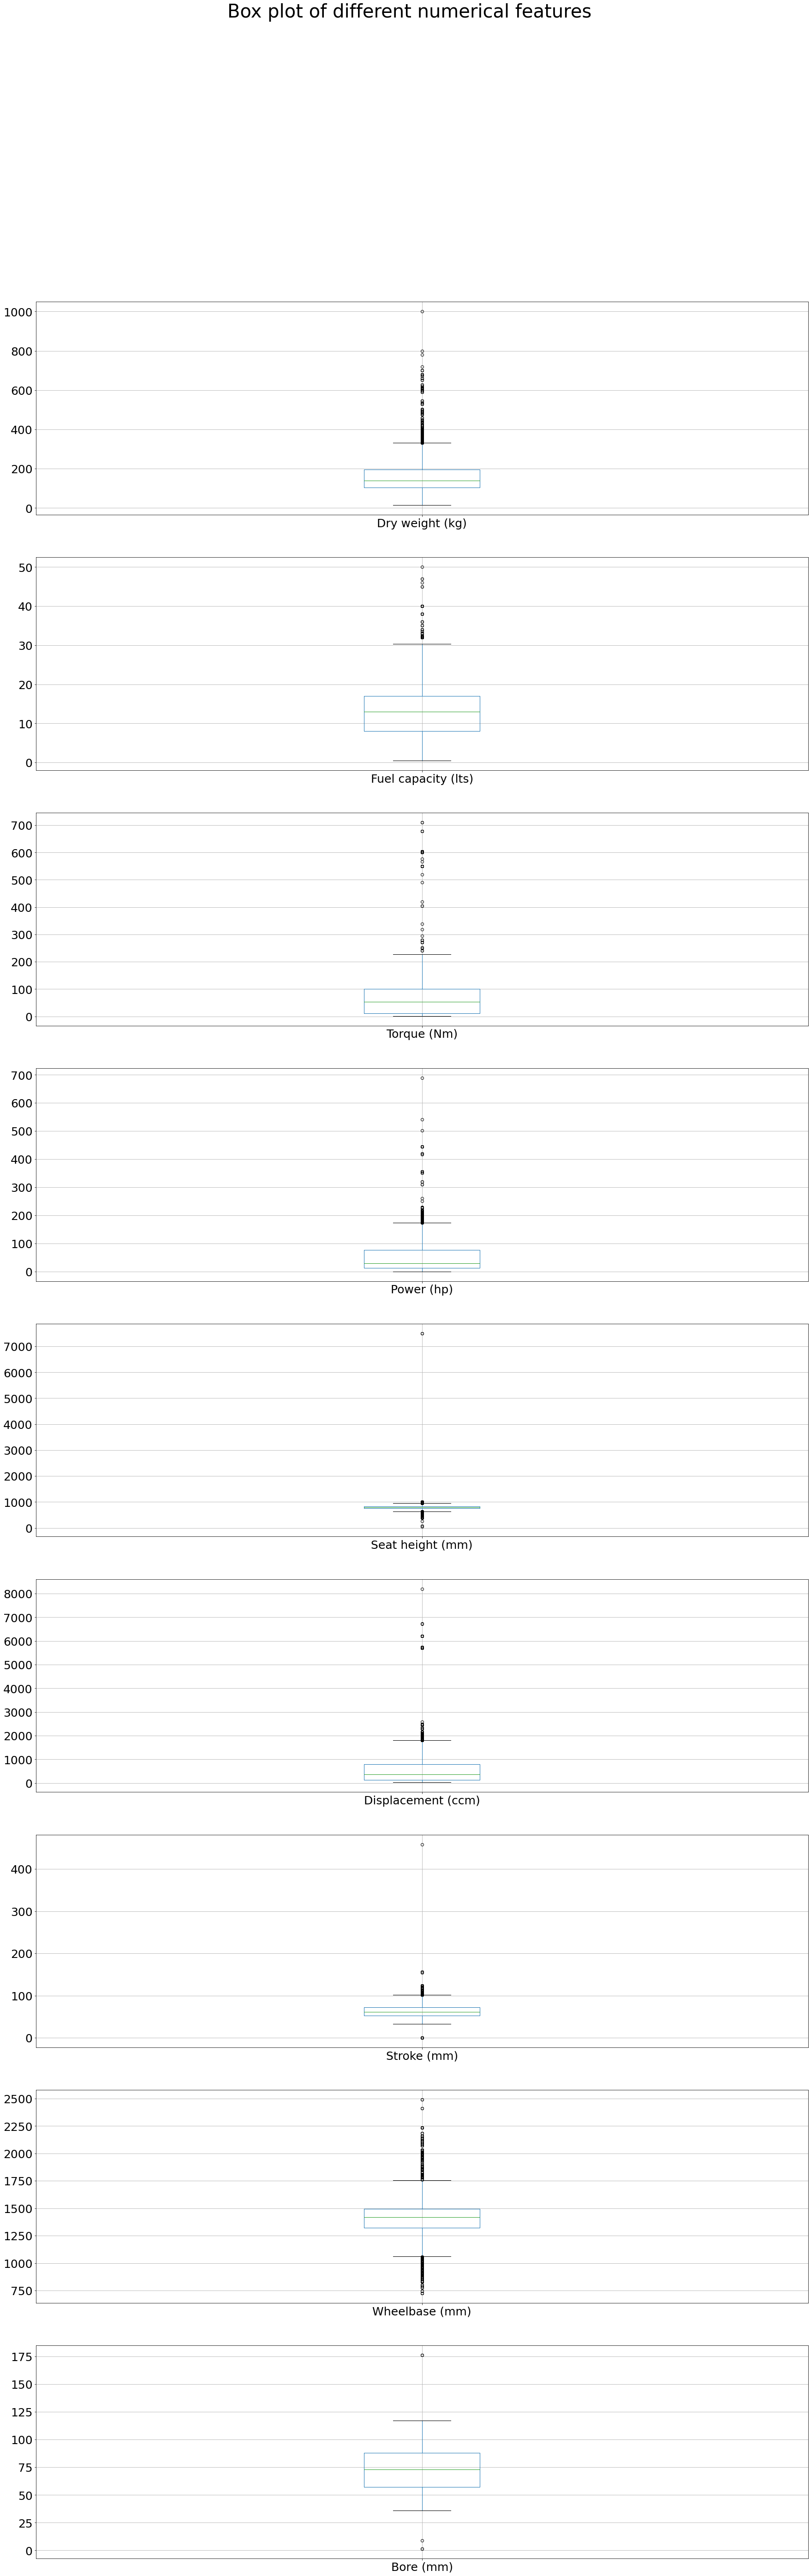

In [16]:
numerical_features = workdf.loc[:, list(features_name)].\
select_dtypes(include=[np.number])  
            # considering only features whose values are not categorical,                                                                         
                # draw a box plot

plt.figure(figsize=(30, 90))
plt.suptitle('Box plot of different numerical features', fontsize = 40)
plot_counter = 1
for column in numerical_features.columns:
    plt.subplot(len(numerical_features.columns),1,plot_counter)
    plot_counter+=1
    numerical_features.boxplot(column=column)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)

In [17]:
from statistics import mode

for column in numerical_features.columns:
    feature_values = numerical_features[column]
    mean = feature_values.mean()
    variance = feature_values.var()
    std_deviation = feature_values.std()
    median = feature_values.median()
    mode_value = mode(feature_values)
    print(f"Column: {column}")
    print(f"\tMean: {mean}")
    print(f"\tVariance: {variance} (Standard deviation: {std_deviation})")
    print(f"\tMode: {mode_value}")
    print(f"\tMedian: {median}")
    print()

Column: Dry weight (kg)
	Mean: 161.24265927977854
	Variance: 7213.2708660164 (Standard deviation: 84.93097706971467)
	Mode: 110.0
	Median: 140.0

Column: Fuel capacity (lts)
	Mean: 13.073586113615882
	Variance: 36.32543157004767 (Standard deviation: 6.027058284938654)
	Mode: 17.0
	Median: 13.0

Column: Torque (Nm)
	Mean: 63.11679851876782
	Variance: 4056.5032598498274 (Standard deviation: 63.69068424699037)
	Mode: 60.0
	Median: 54.1

Column: Power (hp)
	Mean: 50.48904317639402
	Variance: 2675.684503999229 (Standard deviation: 51.72701909059934)
	Mode: 27.0
	Median: 29.4

Column: Seat height (mm)
	Mean: 791.5507835171213
	Variance: 18036.922861877483 (Standard deviation: 134.30161153864643)
	Mode: 790.0
	Median: 790.0

Column: Displacement (ccm)
	Mean: 543.4662966851658
	Variance: 289775.67639495526 (Standard deviation: 538.3081611818227)
	Mode: 125.0
	Median: 354.0

Column: Stroke (mm)
	Mean: 64.59754488112526
	Variance: 340.0976230478999 (Standard deviation: 18.441735901153663)
	Mode:

As can be observed from the sampling distribution represented by the box plots and the statistical measures reported above, many numerical features exhibit very high variances, significantly deviating from the mean. Additionally, there are a considerable number of outliers present.

This suggests that replacing missing values with measures such as the mean, median, or mode, as well as sampling from a Gaussian distribution, would lead to data distortion and not provide an accurate estimation of the missing values.

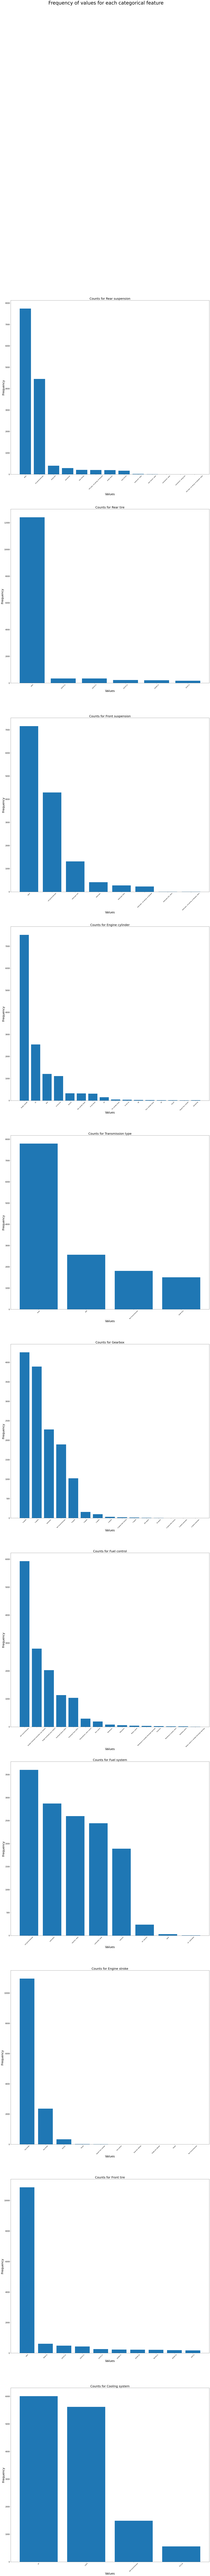

In [18]:
categorical_features = workdf.loc[:, list(features_name)].select_dtypes\
(exclude=[np.number]) 
# considering only features whose values are categorical

counts = {}
for column in categorical_features.columns:  # Calculate the counts for each column
    counts[column] = categorical_features[column].value_counts(dropna=True)

th = 15
plt.figure(figsize=(30, 350))
plt.suptitle('Frequency of values for each categorical feature ', fontsize = 40)
plot_counter = 1
for column, count in counts.items():
    if len(count)>th:
        count_top_th = count.head(th)
        sum_remaining = count.iloc[th:].sum()
        count_top_th['Remaining'] = sum_remaining
        plt.subplot(len(categorical_features.columns),1,plot_counter)
        plot_counter+=1
        plt.bar(count_top_th.index, count_top_th.values)
        plt.xlabel('Values', fontsize = 25)
        plt.xticks(rotation=45)
        plt.yticks(fontsize = 15)
        plt.ylabel('Frequency', fontsize = 25)
        plt.title(f"Counts for {column}", fontsize = 25)
    else:
        plt.subplot(len(categorical_features.columns),1,plot_counter)
        plot_counter+=1
        plt.bar(count.index, count.values)
        plt.xlabel('Values', fontsize = 25)
        plt.xticks(rotation=45)
        plt.yticks(fontsize = 15)
        plt.ylabel('Frequency', fontsize = 25)
        plt.title(f"Counts for {column}", fontsize = 25)

In the case of the categorical features, the frequency analysis of each unique value reveals a lack of homogeneity in the graphs. Some features exhibit a single value that is significantly more frequent than others, while others show three or four values with notably higher frequencies than the average. Additionally, several features display numerous values with similarly low frequencies.

All of this suggests the absence of a unified strategy.

Based on the information provided, the following strategy was employed to replace the missing data.

For each feature, a probability distribution was created based on the sampling distribution of the available values. The missing values were then sampled from this distribution. The more frequent a particular value was present in the data, the more likely it was to be sampled.

This approach was designed to preserve information (all available values were retained) and to account for the heterogeneity in the distribution of values within each feature.

In [19]:
def fill_missing_values_with_sampling(df, column_name):
    column = df[column_name]

    # Calculate probability distribution from available data
    available_data_column = column.dropna()  # Remove missing values
    probability_distribution = available_data_column.value_counts(normalize=True)

    # Generate random samples from the probability distribution
    num_missing_values = column.isnull().sum()
    fill_samples = np.random.choice(probability_distribution.index,\
                                    size=num_missing_values,\
                                    p=probability_distribution.values)
    # Replace missing values with generated samples
    column_filled = column.copy()
    column_filled[column_filled.isnull()] = fill_samples

    return column_filled

workdf_filledNullValues = workdf.copy()
for column in numerical_features.columns:  # fill missing values: only numerical
                                           # features have missing values
    if numerical_features[column].isnull().any():
        workdf_filledNullValues[column] = \
        fill_missing_values_with_sampling(numerical_features, column)

In [20]:
# Evaluation after missing value replacement.

print("Percentage of missing values by column.")
percs = (workdf_filledNullValues.isnull().mean() * 100).sort_values(ascending=False)
for c, p in percs.items():
    print(f"\t{c}: {p:.2f}%")

Percentage of missing values by column.
	Rating: 46.52%
	Model: 0.07%
	Brand: 0.00%
	Fuel control: 0.00%
	Front suspension: 0.00%
	Rear tire: 0.00%
	Front tire: 0.00%
	Fuel system: 0.00%
	Seat height (mm): 0.00%
	Wheelbase (mm): 0.00%
	Dry weight (kg): 0.00%
	Transmission type: 0.00%
	Cooling system: 0.00%
	Stroke (mm): 0.00%
	Fuel capacity (lts): 0.00%
	Bore (mm): 0.00%
	Gearbox: 0.00%
	Engine stroke: 0.00%
	Engine cylinder: 0.00%
	Torque (Nm): 0.00%
	Power (hp): 0.00%
	Displacement (ccm): 0.00%
	Category: 0.00%
	Year: 0.00%
	Rear suspension: 0.00%


In [21]:
display(workdf_filledNullValues)

Brand                   Model  Year                   Category  \
1      acabion                 gtbo 55  2007                      Sport   
4      acabion                 gtbo 70  2007  Prototype / concept model   
6       access     ams 3.20 supercross  2016                        ATV   
7       access  ams 4.30 supermoto efi  2016                        ATV   
8       access  ams 4.38 sm gear shift  2016                        ATV   
...        ...                     ...   ...                        ...   
38459  zündapp            roller super  1968                    Scooter   
38462  zündapp                   z 2 g  1923                      Sport   
38466  zündapp                    z 22  1923                      Sport   
38468  zündapp                   z 249  1923                      Sport   
38471  zündapp                   z 300  1929                      Sport   

       Rating  Displacement (ccm)  Power (hp)  Torque (Nm)  Engine cylinder  \
1         2.6              1300.0       541.0        420.0     In-line four   
4         3.1              1300.0       689.0        490.0     In-line four   
6         NaN               280.0        18.8         41.3  Single cylinder   
7         NaN               359.3        29.5        106.0  Single cylinder   
8         NaN               449.0        37.6        133.0  Single cylinder   
...       ...                 ...         ...          ...              ...   
38459     NaN                49.0        95.0        100.0  Single cylinder   
38462     NaN               211.0         2.8         54.0  Single cylinder   
38466     NaN               211.0         2.3         49.0  Single cylinder   
38468     NaN               249.0         2.8         80.0  Single cylinder   
38471     NaN               298.0        26.0         38.5  Single cylinder   

      Engine stroke  ... Cooling system  Transmission type  Dry weight (kg)  \
1       four-stroke  ...         Liquid  Not Given/Unknown            360.0   
4       four-stroke  ...         Liquid  Not Given/Unknown            300.0   
6       four-stroke  ...            Air              Chain            225.0   
7       four-stroke  ...            Air              Chain            236.0   
8       four-stroke  ...            Air              Chain            236.0   
...             ...  ...            ...                ...              ...   
38459    two-stroke  ...            Air  Not Given/Unknown             83.5   
38462    two-stroke  ...            Air               Belt             73.0   
38466    two-stroke  ...            Air               Belt             58.0   
38468    two-stroke  ...            Air               Belt             76.0   
38471    two-stroke  ...            Air              Chain            105.0   

       Wheelbase (mm) Seat height (mm)         Fuel system Front tire  \
1              1495.0            670.0               other      other   
4              1481.0            815.0               other      other   
6              1150.0            739.0         carburettor      other   
7              1476.0            660.0      efi. injection      other   
8              1475.0            830.0         carburettor      other   
...               ...              ...                 ...        ...   
38459          1476.0            840.0  carburettor. other      other   
38462          1350.0            735.0         carburettor      other   
38466           910.0            880.0         carburettor      other   
38468          1485.0            915.0         carburettor      other   
38471          1229.0            671.0         carburettor      other   

       Rear tire   Front suspension    Rear suspension  
1          other  not given/unknown  not given/unknown  
4          other  not given/unknown  not given/unknown  
6          other  not given/unknown  not given/unknown  
7          other  not given/unknown  not given/unknown  
8          other              other  not given/u

## Exercise 2: Encoding of categorical data
Since PCA requires fully numerical features, the categorical features in the current database need to be encoded to serve this purpose. Specifically, one-hot encoding has been chosen as the encoding method.

Each unique value related to a specific feature is encoded as 1 (indicating its presence) or 0 (indicating its absence) in the one-hot encoding process.

Particular attention is also given to the subset of columns that have multiple values separated by a delimiter (for details, refer to the code snippet below). Each individual value is extracted and placed in a specific separate column.

As a result of this process, the number of features is significantly higher compared to the original number, but any implicit order among the categories is created.

In [22]:
# visualize categorical features with original encoding
display(workdf_filledNullValues.loc[:, list(categorical_features_name)])

Engine cylinder   Front suspension    Rear suspension  \
1         In-line four  not given/unknown  not given/unknown   
4         In-line four  not given/unknown  not given/unknown   
6      Single cylinder  not given/unknown  not given/unknown   
7      Single cylinder  not given/unknown  not given/unknown   
8      Single cylinder              other  not given/unknown   
...                ...                ...                ...   
38459  Single cylinder  not given/unknown  not given/unknown   
38462  Single cylinder              other              other   
38466  Single cylinder              other              other   
38468  Single cylinder              other              other   
38471  Single cylinder  not given/unknown  not given/unknown   

       Transmission type            Gearbox           Fuel control Rear tire  \
1      Not Given/Unknown            6-speed      Not Given/Unknown     other   
4      Not Given/Unknown            6-speed      Not Given/Unknown     other   
6                  Chain          Automatic  Overhead Valves (OHV)     other   
7                  Chain          Automatic    Overhead Cams (OHC)     other   
8                  Chain            5-speed    Overhead Cams (OHC)     other   
...                  ...                ...                    ...       ...   
38459  Not Given/Unknown  Not Given/Unknown      Not Given/Unknown     other   
38462               Belt            2-speed      Not Given/Unknown     other   
38466               Belt  Not Given/Unknown      Not Given/Unknown     other   
38468               Belt            3-speed      Not Given/Unknown     other   
38471              Chain  Not Given/Unknown  Overhead Valves (OHV)     other   

              Fuel system Engine stroke Front tire Cooling system  
1                   other   four-stroke      other         Liquid  
4                   other   four-stroke      other         Liquid  
6             carburettor   four-stroke      other            Air  
7          efi. injection   four-stroke      other            Air  
8             carburettor   four-stroke      other            Air  
...                   ...           ...        ...            ...  
38459  carburettor. other    two-stroke      other            Air  
38462         carburettor    two-stroke      other            Air  
38466         carburettor    two-stroke      other            Air  
38468         carburettor    two-stroke      other            Air  
38471         carburettor    two-stroke      other            Air  

[13673 rows x 11 columns]

In [23]:
Xworkdf = workdf_filledNullValues.loc[:, list(features_name)]  # features selected

separator = '. ' # Values containing the string '. ' have to be split, since it is used
                 # to separate a list of characteristics in a unique string

for column in categorical_features_name:
    split_columns_df = Xworkdf[column].str.split(separator, expand=True) # a dataframe
                                          # with one column for each split is obtained

    for col in split_columns_df.columns: # for each column 'col' of the
                                         # dataframe split_columns_df
        pref = f"{column}_{col}"
        one_hot_encoding_df = pd.get_dummies(split_columns_df[col], prefix=pref)
                                        # a dataframe whose categorical values are
                                        # encoded with 'one hot encoding' is created

        Xworkdf = pd.concat([Xworkdf, one_hot_encoding_df], axis=1)  # append
                                            # the new dataframe to Xworkdf

    Xworkdf = Xworkdf.drop(column, axis=1)  # delete original column since it
                                            # is redudant in the new dataframe

Xfeatures_name = set(Xworkdf.columns)
Xcategorical_features_name = set(Xworkdf.columns) - numerical_features_name

In [24]:
# visualize categorical features with one hot encoding
display(Xworkdf.loc[:, list(Xcategorical_features_name)])

Front tire_0_25/8-12  Front tire_0_110/70-17  Rear tire_0_130/60-13  \
1                         0                       0                      0   
4                         0                       0                      0   
6                         0                       0                      0   
7                         0                       0                      0   
8                         0                       0                      0   
...                     ...                     ...                    ...   
38459                     0                       0                      0   
38462                     0                       0                      0   
38466                     0                       0                      0   
38468                     0                       0                      0   
38471                     0                       0                      0   

       Fuel control_4_discharg  Fuel control_2_  Rear tire_0_120/70-12  \
1                            0                0                      0   
4                            0                0                      0   
6                            0                0                      0   
7                            0                0                      0   
8                            0                0                      0   
...                        ...              ...                    ...   
38459                        0                0                      0   
38462                        0                0                      0   
38466                        0                0                      0   
38468                        0                0                      0   
38471                        0                0                      0   

       Front tire_0_90/90-21  Gearbox_0_4-speed  Fuel control_3_valve  \
1                          0                  0                     0   
4                          0                  0                     0   
6                          0                  0                     0   
7                          0                  0                     0   
8                          0                  0                     0   
...                      ...                ...                   ...   
38459                      0                  0                     0   
38462                      0                  0                     0   
38466                      0                  0                     0   
38468                      0                  0                     0   
38471                      0                  0                     0   

       Engine stroke_0_Singl  ...  Engine cylinder_2_boxer  \
1                          0  ...                        0   
4                          0  ...                        0   
6                          0  ...                        0   
7                          0  ...                        0   
8                          0  ...                        0   
...                      ...  ...                      ...   
38459                      0  ...                        0   
38462                      0  ...                        0   
38466                      0  ...                        0   
38468                      0  ...                        0   
38471                      0  ...                        0   

       Transmission type_0_Belt  Engine cylinder_0_Electric  \
1                             0                           0   
4                             0                           0   
6                             0                           0   
7                             0                           0   
8                             0                           0   
...                         ...                         ...   
38459                         0                           0   
38462                         1                        

## Exercise 3: Preprocessing and PCA
Before applying PCA, it is necessary to apply data preprocessing techniques.

The following tecniques have been considered.

- StandardScaler: it standardizes features by removing the mean and scaling to unit variance
- MinMaxScaler; it scales and translates each feature to a specific range, such as between zero and one, based on the training set.

In [25]:
standardScaler_instance = StandardScaler()

range = (0,1)
minMaxScaler_instance = MinMaxScaler(feature_range=range)

Xworkdf_std = pd.DataFrame(standardScaler_instance.fit_transform(Xworkdf),\
                           columns=Xworkdf.columns)
Xworkdf_mm = pd.DataFrame(minMaxScaler_instance.fit_transform(Xworkdf),\
                          columns=Xworkdf.columns)

In [26]:
print("Variance of multiple dataframes.")

variance_of_DataFrames = pd.DataFrame({
    'Xworkdf': Xworkdf.var(),
    'Xworkdf_std': Xworkdf_std.var(),
    'Xworkdf_mm': Xworkdf_mm.var()
})

level2 = list(Xworkdf)
level1 = ['numerical features'] * len(numerical_features_name) +\
['categorical features'] * (len(level2) - len(numerical_features_name))
multi_index = pd.MultiIndex.from_arrays([level1, level2],\
                                        names=['feature type', 'feature name'])
variance_of_DataFrames.index = multi_index
display(variance_of_DataFrames)

Variance of multiple dataframes.


Xworkdf  \
feature type         feature name                                   
numerical features   Dry weight (kg)                  7069.491917   
                     Fuel capacity (lts)                35.850689   
                     Torque (Nm)                      4135.065512   
                     Power (hp)                       2678.183682   
                     Seat height (mm)                17548.138589   
...                                                           ...   
categorical features Cooling system_0_No                 0.097048   
                     Cooling system_0_Oi                 0.039215   
                     Cooling system_1_                   0.039215   
                     Cooling system_1_Given/Unknown      0.097048   
                     Cooling system_2_air                0.039215   

                                                     Xworkdf_std  Xworkdf_mm  
feature type         feature name                                             
numerical features   Dry weight (kg)                    1.000073    0.007288  
                     Fuel capacity (lts)                1.000073    0.014631  
                     Torque (Nm)                        1.000073    0.008238  
                     Power (hp)                         1.000073    0.005647  
                     Seat height (mm)                   1.000073    0.000315  
...                                                          ...         ...  
categorical features Cooling system_0_No                1.000073    0.097048  
                     Cooling system_0_Oi                1.000073    0.039215  
                     Cooling system_1_                  1.000073    0.039215  
                     Cooling system_1_Given/Unknown     1.000073    0.097048  
                     Cooling system_2_air               1.000073    0.039215  

[185 rows x 3 columns]

Variances of features in original dataset and variances of the scaled datasets have been compared.

Variance measures the spread of values in a set of values around the mean.

It is very important to apply data scaling techniques as PCA tecnique is based on the following concept: *higher variance indicates a more informative feature*.

The analysis of variances for individual features reveals a significant change before and after both scaling processes. This change is particularly pronounced in the case of categorical features.

### PCA application
Principal Component Analysis (PCA) is applied to three different versions of the preprocessed dataset: original, scaled via StandardScaler and scaled via MinMaxScaler.
In this phase, we apply Principal Component Analysis on the preprocessed dataset:
- original dataset
- dataset whose features are scaled via StandardScaler
 - dataset whose features are scaled via MinMaxScaler

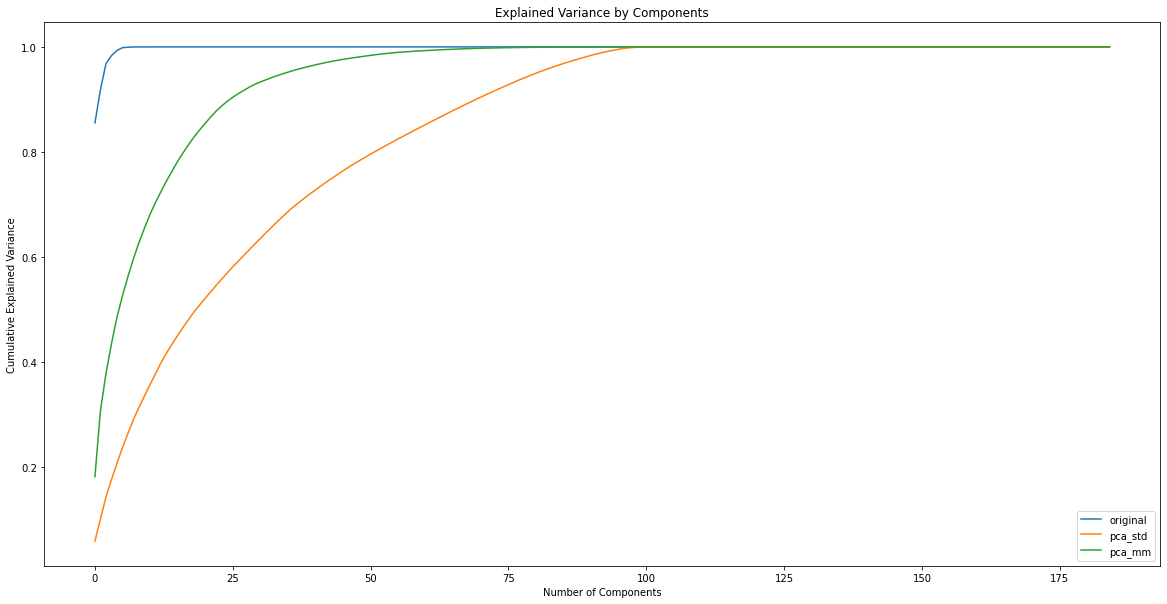

In [27]:
pca_instances = {
    'original': PCA(),
    'pca_std': PCA(),
    'pca_mm': PCA()
}

dataFrames = {
    'original': Xworkdf,
    'pca_std': Xworkdf_std,
    'pca_mm': Xworkdf_mm
}

for k in pca_instances.keys():
    pca_instances[k].fit(dataFrames[k])

# Plotting cumulative explained variance
plt.figure(figsize=(20, 10))

for k in pca_instances.keys():
    plt.plot(np.cumsum(pca_instances[k].explained_variance_ratio_), label=k)

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.legend()
plt.show()

The **cumulative explained variance** for each dataset is plotted and then evaluated. It shows the proportion of the total variance encapsulated within the first N components.

If a given percentage $\alpha %$ of the variance is contained within the first N components, it implies that it is possible to reduce available data to N dimensions whilst retaining $\alpha %$ of its variance.

As can be seen from the plot, the original dataset requires a significant lower number of principal components to retain an given percentage of variance of data.
This is happens since PCA is sensitive to the variances of the feature scales. The fact the original dataset is not scaled reflects in features with high variances dominating the principal components therefore leading to a less balanced representation of the original features.

# Exercise 4: Dimensionality Reduction and Interpretation of the PCs

PCA is used to make the dataset less dimensional while still attempting to retain the majority of the original variance (or an acceptable percentage).

The minimum number of principal components required to explain at least 35% of the total variance for the scaled dataset described above is computed.

In [28]:
keys_to_be_considered = ['pca_std', 'pca_mm']  # for this part, only the corresponding
                                               # dataframes has to be considered

In [29]:
def min_PCs(explained_variance_ratio, threshold):
    """
    Calculates the minimum number of principal components needed to explain a given
    threshold proportion of the total variance.

    Parameters:
    - explained_variance_ratio (list or array-like): A list or array containing the
        explained variance ratio for each principal component.
    - threshold (float): The threshold proportion of the total variance to be
        explained, expressed as a percentage.

    Returns:
    - int: The minimum number of principal components required to explain
            the specified threshold proportion of the total variance.
           Returns -1 if an error occurs.

    Example usage:
    >>> explained_variances = [0.3, 0.2, 0.15, 0.1, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01]
    >>> threshold = 80
    >>> min_components = min_PCs(explained_variances, threshold)
    >>> print(min_components)
    6
    """

    threshold /= 100  # Convert threshold from percentage to ratio
    cumulative_explained_variance_ratio = 0

    for i, val in enumerate(explained_variance_ratio):
        cumulative_explained_variance_ratio += val  # Calculate cumulative explained 
                                                    # variance ratio up to i
        if cumulative_explained_variance_ratio >= threshold:  # Check if cumulative
            # explained variance ratio is greater than or equal to the threshold
            return i + 1  # Return the number of components needed to explain the
                          # threshold proportion of the total variance

    return -1  # Return -1 if an error occurs


In [30]:
max_comp = 5
min_number_components = {}
for k in keys_to_be_considered:
    min_number_components[k] = min_PCs(pca_instances[k].explained_variance_ratio_, 35)
    # Number of components needed to explain at least 35% of the total variance.

m = {}
for k in keys_to_be_considered:
    m[k] = min(min_number_components[k], max_comp)  # limit the number of components
                                                    # to a maximum fixed value

for k in keys_to_be_considered:
    print(f"{k}.")
    print(f"\tm = {m[k]} (min between {max_comp} and\
    {min_number_components[k]}, number of components needed\
    to explain at least 35% of the total variance.)")

pca_std.
	m = 5 (min between 5 and    11, number of components needed    to explain at least 35% of the total variance.)
pca_mm.
	m = 3 (min between 5 and    3, number of components needed    to explain at least 35% of the total variance.)


- Standardized data: 11 components are needed to explain at least 35% of the total variance, but only the first 5 are selected.
- Min/Max scaled data: 3 Components are needed to explain at least 35% of the total variance

The fact that fewer components are required to explain the same percentage of the overall variance implies that the MinMax scaled data is less difficult or simpler to deal with than the standardized data.

The barplots of percentage of explained variance, with respect to the PCs considered above have been plot.

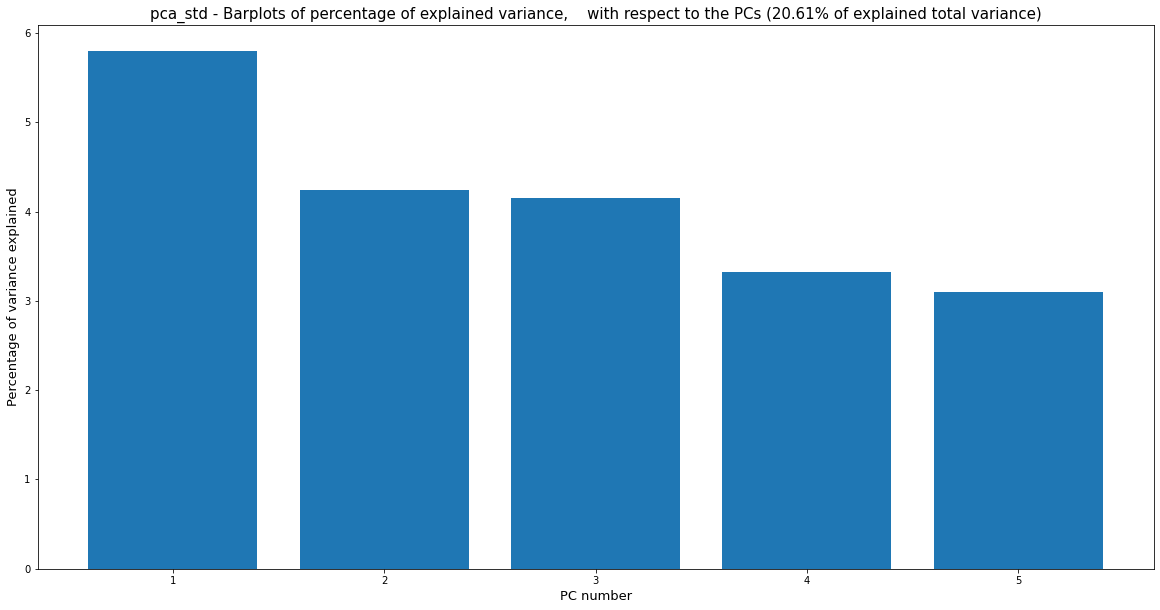

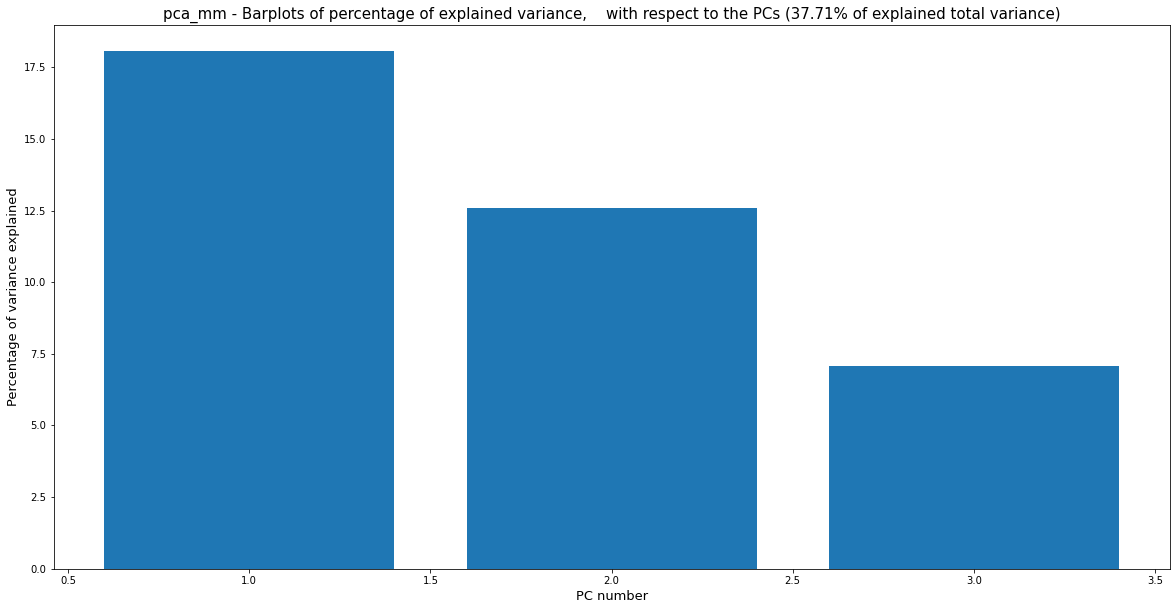

In [31]:
for k in keys_to_be_considered:
    # Plotting barplots of percentage of explained variance, with respect to the PCs
    plt.figure(figsize=(20, 10))

    round_expl_var_ratio = np.round(pca_instances[k].\
                                    explained_variance_ratio_[:m[k]].sum() * 100,\
                                    decimals=2) # Total explained variance
    plt.bar(np.arange(1, m[k]+1), 100 * pca_instances[k].\
            explained_variance_ratio_[:m[k]])

    plt.xlabel('PC number', fontsize = 13)
    plt.ylabel('Percentage of variance explained', fontsize = 13)
    plt.title(f'{k} - Barplots of percentage of explained variance,\
    with respect to the PCs ({round_expl_var_ratio}% of explained total variance)',\
              fontsize = 15)

The top features that contribute the most to each of the first few main components for the two datasets are listed in the excerpt that follows. The features are sorted according to the absolute values of the weights they get in the PCs, with the top features receiving the greatest weights. This ranking gives information about the original factors that are responsible for the separation in the data that is shown in the PCs: components that carry the heaviest weights are thought to affect the PC the most.

In [32]:
top_features_number =  5  # number of features with the highest absolute weight in a PC

for k in keys_to_be_considered:  # for each dataframe
    top_features_df = pd.DataFrame()
    i = 0 # 1st PC
    while i < (m[k]): # for each PC among the first m Pcs
        p = pca_instances[k].components_[i]  # weights in the PC
        feat_names = dataFrames[k].columns # corresponding feature (i.e., name)
        top_features = sorted([(w, n) for w, n in zip(p, feat_names)], \
                              key=lambda tup: -abs(tup[0]))[:top_features_number] 
                                # top features with the highest absolute weights

        # store information in a DataFrame for visualization purposes
        for count, f in enumerate(top_features):
            level1 = [f"PC{i+1}"]
            level2 = [count+1]
            multi_index = pd.MultiIndex.from_arrays([level1, level2], \
                                                    names=['PC', 'rank'])
            top_features_df = pd.concat([top_features_df, \
                                         pd.DataFrame({"Name": [f[1]],\
                                                       "Weight": [f[0]]}, multi_index)])

        i+=1 # next PC

    extern_level_columns = pd.MultiIndex.from_tuples([('Feature', 'Name'),\
                                                      ('Feature', 'Weight')])
    top_features_df.columns = extern_level_columns

    print("Number of features with the highest absolute weight in a PC" + " - " + k)
    display(top_features_df)

Number of features with the highest absolute weight in a PC - pca_std


Feature          
                                      Name    Weight
PC  rank                                            
PC1 1               Fuel control_1_Overhea  0.207733
    2                    Fuel control_3_Ca  0.205900
    3                Fuel control_4_(DOHC)  0.205900
    4                 Fuel control_0_Doubl  0.205900
    5              Fuel control_2_Cams/Twi  0.205900
PC2 1                 Rear suspension_0_no  0.268512
    2      Rear suspension_1_given/unknown  0.268512
    3     Front suspension_1_given/unknown  0.267222
    4                Front suspension_0_no  0.267222
    5              Rear suspension_0_other -0.220356
PC3 1               Rear suspension_1_type  0.277248
    2                Rear suspension_2_coi  0.277248
    3             Rear suspension_3_spring  0.277248
    4                 Rear suspension_4_oi  0.277248
    5             Rear suspension_5_damped  0.277248
PC4 1                Engine stroke_0_Squar  0.377061
    2                  Engine stroke_1_fou  0.377061
    3             Engine stroke_2_cylinder  0.377061
    4           Engine cylinder_2_cylinder  0.377061
    5              Engine cylinder_0_Squar  0.377061
PC5 1             Engine cylinder_2_Wankel  0.394210
    2                  Engine stroke_1_dis  0.394210
    3               Engine stroke_2_Wankel  0.394210
    4                Engine cylinder_1_dis  0.394210
    5                  Engine stroke_0_Dua  0.346415

Number of features with the highest absolute weight in a PC - pca_mm


Feature          
                                      Name    Weight
PC  rank                                            
PC1 1                 Rear suspension_0_no  0.270294
    2      Rear suspension_1_given/unknown  0.270294
    3                Front suspension_0_no  0.264314
    4     Front suspension_1_given/unknown  0.264314
    5              Rear suspension_0_other -0.257855
PC2 1           Engine cylinder_1_cylinder -0.294279
    2              Engine cylinder_0_Singl -0.294196
    3            Fuel system_0_carburettor -0.246047
    4     Front suspension_1_given/unknown  0.215935
    5                Front suspension_0_no  0.215935
PC3 1                    Fuel control_0_No -0.316091
    2         Fuel control_1_Given/Unknown -0.316091
    3                   Fuel control_2_Cam  0.258153
    4                Fuel control_3_(SOHC)  0.258153
    5                 Fuel control_0_Singl  0.258153

The PCA scores, which reflect data projected onto the PCs (i.e., on m PCs as computed above), are then computed for the dataset. These results are used to create a scatter plot in 2D or 3D with point marked according to the original dataset's classifications. This visualization makes it easier to comprehend how the data are distributed in the space with fewer dimensions.

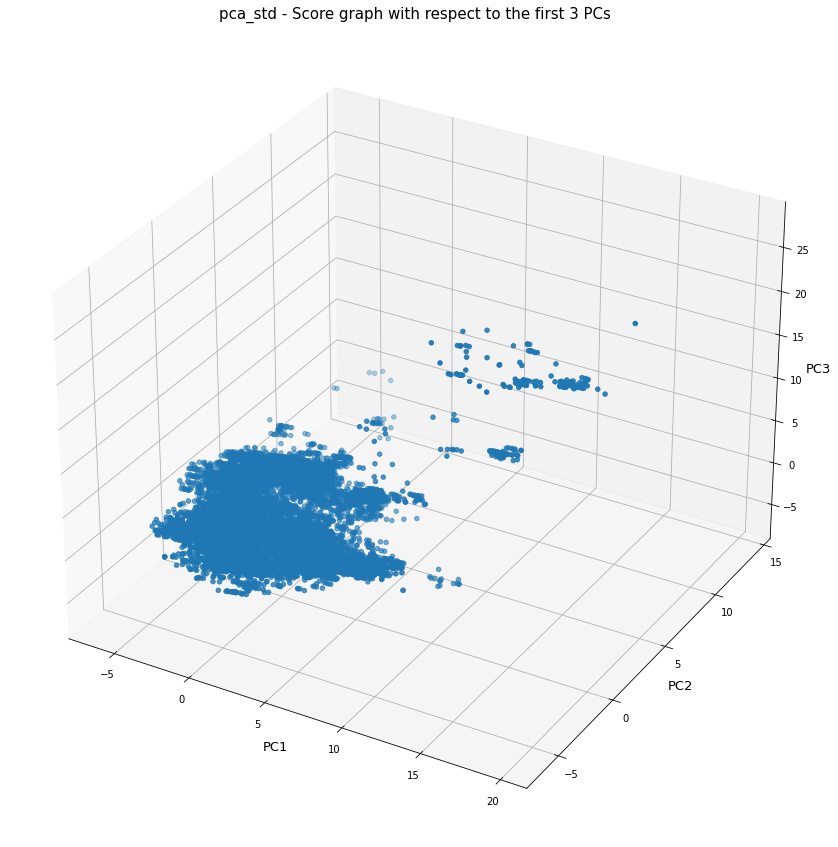

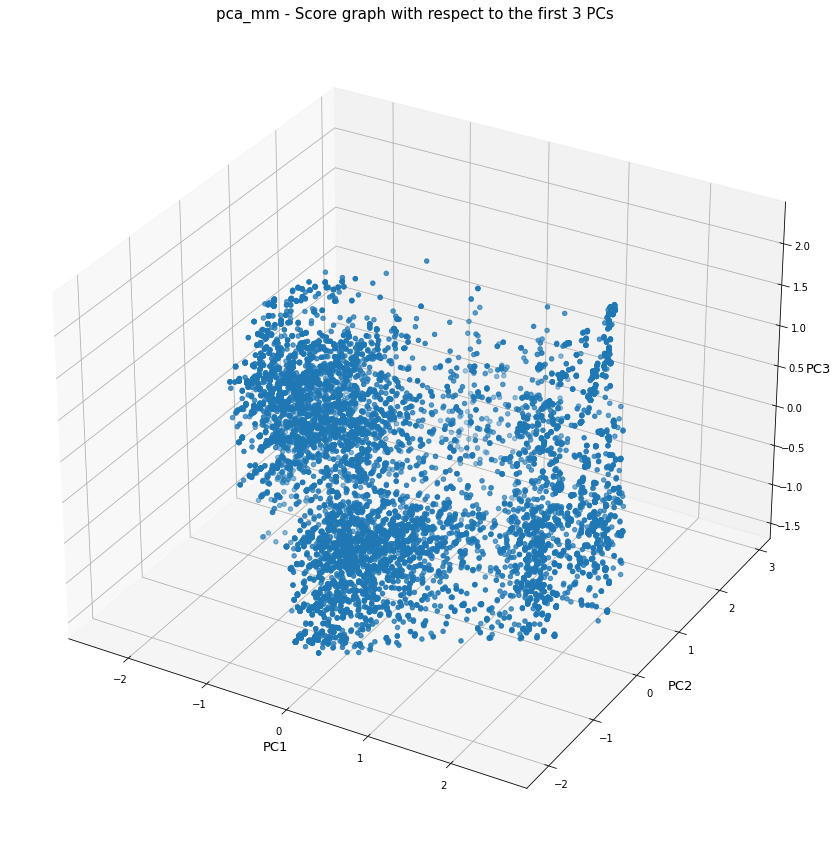

In [33]:
for k in keys_to_be_considered:
    df_transformed = pca_instances[k].transform(dataFrames[k])  # apply PCA
                                                                # transformation
    scores = df_transformed[:, :m[k]]  # compute scores for the first m PCs

    # score graph with respect to the first l PCs
    if m[k] == 2:
        l = 2
        plt.figure(figsize=(20, 18))
        plt.scatter(scores[:, 0], scores[:, 1])
        plt.xlabel("PC1", fontsize=13)  # PC1 on axis x
        plt.ylabel("PC2", fontsize=13)  # PC2 on axis y
        plt.title(f'{k} - Score graph with respect to the first {l} PCs', fontsize=15)
    else:
        l = 3
        fig = plt.figure(figsize=(20, 15))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(scores[:, 0], scores[:, 1], scores[:, 2])
        ax.set_xlabel("PC1", fontsize=13)  # PC1 on axis x
        ax.set_ylabel("PC2", fontsize=13)  # PC2 on axis y
        ax.set_zlabel("PC3", fontsize=13)  # PC3 on axis z
        plt.title(f'{k} - Score graph with respect to the first {l} PCs', fontsize=15)

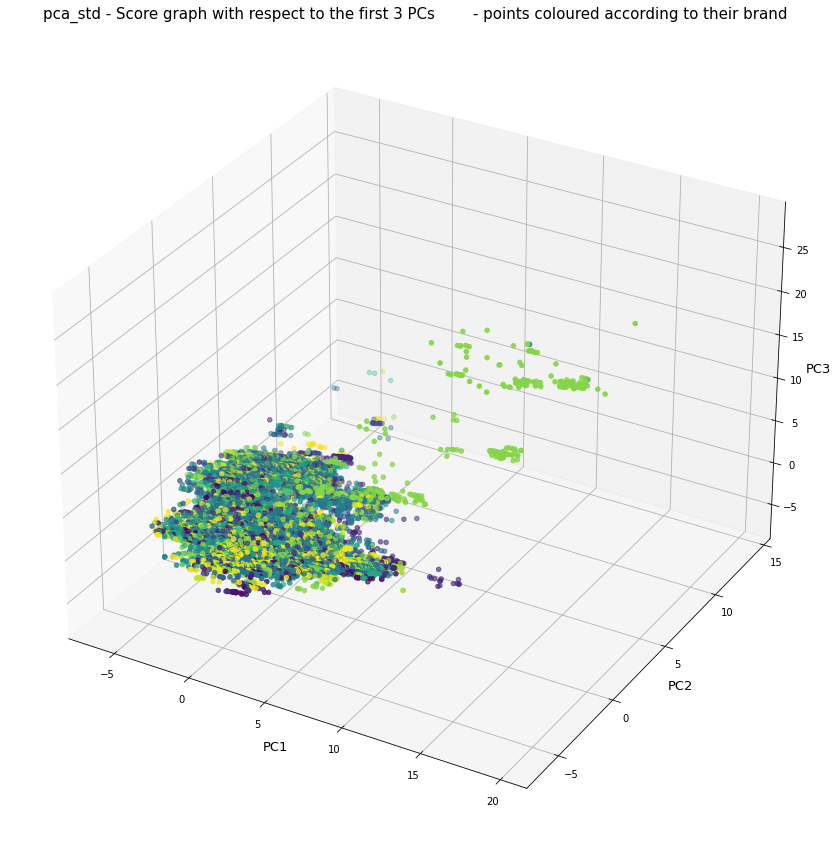

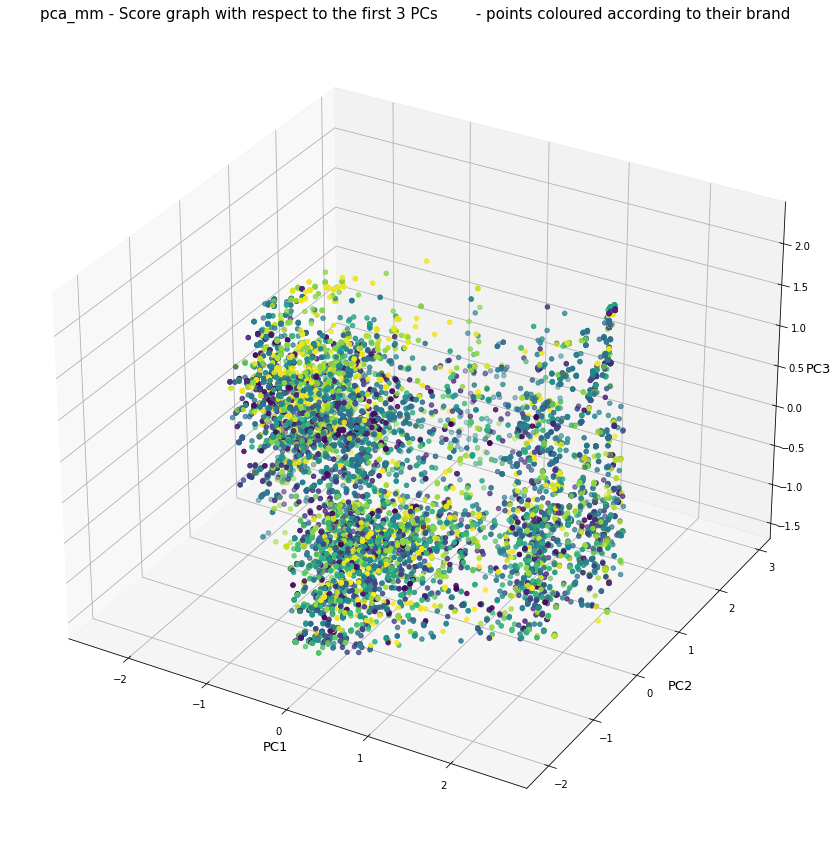

In [34]:
label = pd.factorize(workdf['Brand'])[0]  # encode 'Brand' column with numbers to color
                                          # points according to brand

for k in keys_to_be_considered:
    df_transformed = pca_instances[k].transform(dataFrames[k])  # apply PCA
                                                                # transformation
    scores = df_transformed[:, :m[k]]  # compute scores for the first m PCs

    # score graph with respect to the first l PCs - points coloured according to
    # their brand
    if m[k] == 2:
        l = 2
        plt.figure(figsize=(20, 18))
        plt.scatter(scores[:, 0], scores[:, 1], c = label)
        plt.xlabel("PC1", fontsize=13)  # PC1 on axis x
        plt.ylabel("PC2", fontsize=13)  # PC2 on axis y
        plt.title(f'{k} - Score graph with respect to the first {l} PCs\
        - points coloured according to their brand', fontsize=15)
    else:
        l = 3
        fig = plt.figure(figsize=(20, 15))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(scores[:, 0], scores[:, 1], scores[:, 2], c = label)
        ax.set_xlabel("PC1", fontsize=13)  # PC1 on axis x
        ax.set_ylabel("PC2", fontsize=13)  # PC2 on axis y
        ax.set_zlabel("PC3", fontsize=13)  # PC3 on axis z
        plt.title(f'{k} - Score graph with respect to the first {l} PCs\
        - points coloured according to their brand', fontsize=15)

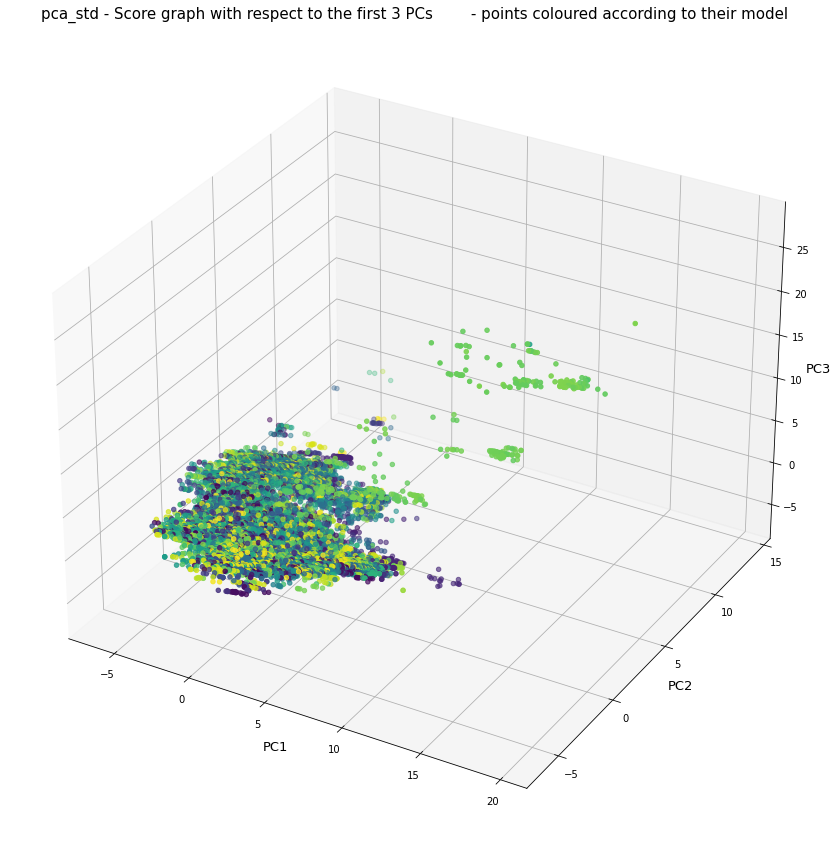

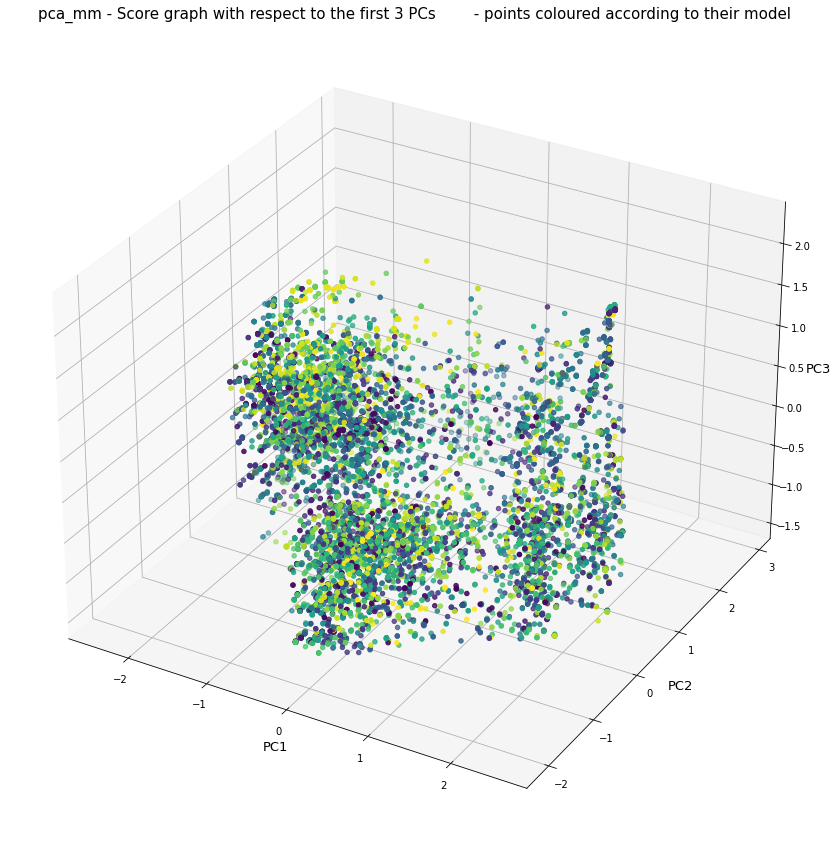

In [35]:
label = pd.factorize(workdf['Model'])[0]  # encode 'Model' column with numbers to color
                                          # points according to model

for k in keys_to_be_considered:
    df_transformed = pca_instances[k].transform(dataFrames[k])  # apply PCA
                                                                # transformation
    scores = df_transformed[:, :m[k]]  # compute scores for the first m PCs

    # score graph with respect to the first l PCs - points coloured according to their
    # model
    if m[k] == 2:
        l = 2
        plt.figure(figsize=(20, 18))
        plt.scatter(scores[:, 0], scores[:, 1], c = label)
        plt.xlabel("PC1", fontsize=13)  # PC1 on axis x
        plt.ylabel("PC2", fontsize=13)  # PC2 on axis y
        plt.title(f'{k} - Score graph with respect to the first {l} PCs -\
        points coloured according to their model', fontsize=15)
    else:
        l = 3
        fig = plt.figure(figsize=(20, 15))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(scores[:, 0], scores[:, 1], scores[:, 2], c = label)
        ax.set_xlabel("PC1", fontsize=13)  # PC1 on axis x
        ax.set_ylabel("PC2", fontsize=13)  # PC2 on axis y
        ax.set_zlabel("PC3", fontsize=13)  # PC3 on axis z
        plt.title(f'{k} - Score graph with respect to the first {l} PCs\
        - points coloured according to their model', fontsize=15)

The purpose of the graphs plotted above is to show the points in the space defined by the PCs considered.

The points are also marked according to their 'Brand' or 'Model'. This is done to search for patterns of categories in the PCs space.

In [36]:
for k in keys_to_be_considered:
    if m[k] == 2:
        l = 2
    else:
        l = 3

    explained_variance_ratio =  pca_instances[k].explained_variance_ratio_[:l]
    print(f"{k} - Explained variance ratio of the first l = {l}",\
          explained_variance_ratio)
    explained_variance_ratio__mean_cum = np.cumsum(explained_variance_ratio)\
    .mean()
    print(f"{k} - Mean cumulative explained variance",\
          explained_variance_ratio__mean_cum)

pca_std - Explained variance ratio of the first l = 3 [0.05796135 0.0424229  0.04156129]
pca_std - Mean cumulative explained variance 0.10009704469842351
pca_mm - Explained variance ratio of the first l = 3 [0.18062356 0.1257731  0.07067388]
pca_mm - Mean cumulative explained variance 0.2880302452020029


The percentage of overall variation that each PC accounts for is shown by the explained variance ratio for the first 3 PCs. The representation related to the Min/Max scaled dataset is much more effective.


# Exercise 5: **k**-Means

The k-Means clustering algorithm is run with the aim to find out interesting clusters within the data.

The algorithm is run on the PCs space.

In [37]:
# Version 1. Full PC Space

In [38]:
kmeans = {}
silhouette_scores =  {}
k_best = {}
for key in keys_to_be_considered:
    df_transformed = pca_instances[key].transform(dataFrames[key])  # apply PCA
                                                                    # transformation
    df_transformed = pd.DataFrame(df_transformed,\
                                  columns=[f'PC{i+1}' for i in\
                                           np.arange(df_transformed.shape[1])])\
                                                            # corresponding dataFrame

    k_values = np.arange(3, 11) # values for k to be considered in the k-MEANS
                                # algorithm
    silhouette_scores[key] = []
    for k in k_values:
        kmeans[key] = KMeans(n_clusters=k, random_state=rs, n_init=10).\
        fit(df_transformed) # Fit the k-Means model
        silhouette_scores[key].append(silhouette_score(df_transformed,\
                                                       kmeans[key].labels_))
                            # silhouette score computation

    k_best[key] = k_values[np.argmax(silhouette_scores[key])] # optimal number
                    # of clusters such that it maximises the silhouette score
    print(f"{key} - k opt = {k_best[key]}")

    # Run the algorithm with the optimal number of clusters
    kmeans[key] = KMeans(n_clusters=k_best[key], random_state=rs, n_init=10)
    kmeans[key].fit(df_transformed)

pca_std - k opt = 10
pca_mm - k opt = 7


In [39]:
# Version 2. PC Space of dimension m as in ex 4.

In [40]:
kmeans = {}
silhouette_scores =  {}
k_best = {}
for key in keys_to_be_considered:
    df_transformed = pca_instances[key].transform(dataFrames[key])[:, :m[key]]
                                                        # apply PCA transformation
    df_transformed = pd.DataFrame(df_transformed, columns=[f'PC{i+1}' for i in\
                                                           np.arange(m[key])])  
                                                        # corresponding dataFrame

    k_values = np.arange(3, 11) # values for k to be considered in the k-MEANS
                                # algorithm
    silhouette_scores[key] = []
    for k in k_values:
        kmeans[key] = KMeans(n_clusters=k, random_state=rs, n_init=10).\
        fit(df_transformed) # Fit the k-Means model
        silhouette_scores[key].append(silhouette_score(df_transformed,\
                                                       kmeans[key].labels_))
                            # silhouette score computation

    k_best[key] = k_values[np.argmax(silhouette_scores[key])] # optimal number
                    # of clusters such that it maximises the silhouette score
    print(f"{key} - k opt = {k_best[key]}")

    # Run the algorithm with the optimal number of clusters
    kmeans[key] = KMeans(n_clusters=k_best[key], random_state=rs, n_init=10)
    kmeans[key].fit(df_transformed)

pca_std - k opt = 6
pca_mm - k opt = 6


*Silhouette coefficient* is used to evaluate the optimal number of cluster numbers (i.e., the number of clusters maximing such measure is considered).

The silhouette score is a metric used to evaluate the quality of clusters in clustering analysis. It measures how well each sample in a cluster is assigned to its own cluster compared to other clusters. The silhouette score can range from -1 to 1, with higher values indicating better cluster assignments (i.e., a score close to 1 indicates that the sample is well-matched to its own cluster and poorly matched to neighboring clusters.)

# Exercise 6: Clusters and Centroid Interpretation and Visualization

The k-Means algorithm with the optimal number of clusters is run.

In [41]:
primary_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
additional_colors = ['orange', 'purple', 'brown', 'pink']

color_dictionary = {
    0: primary_colors[0],
    1: primary_colors[1],
    2: primary_colors[2],
    3: primary_colors[3],
    4: primary_colors[4],
    5: primary_colors[5],
    6: primary_colors[6],
    7: primary_colors[7],
    8: additional_colors[0],
    9: additional_colors[1],
    10: additional_colors[2],
    11: additional_colors[3]
}

marker_dictionary = {
    0: 'D',  # Rombo
    1: '^',  # Triangolo
    2: 's',  # Quadrato
    3: 'p',  # Pentagono
    4: '*',  # Stella
    5: 'h',  # Esagono
    6: 'H',  # Esagono con spigoli più pronunciati
    7: '+',  # Più
    8: 'x',  # Croce
    9: 'o',  # Cerchio
    10: '.',  # Punto
    11: ',',  # Pixel
}

In [42]:
def name_the_centroid(centroid, points, labels):
    """
    Assigns a name to the centroid based on the surrounding points and their labels.

    Arguments:
    - centroid: array, the coordinates of the centroid
    - points: array, the surrounding points represented as an ND array
    - labels: list of arrays, the labels corresponding to the surrounding points

    Returns:
    - selected_labels: list, the selected labels for the centroid

    Description:
    - Each point contributes to the voting process in an inversely proportional manner
        to its distance from the centroid.
    - Note: If a point has a distance of zero, it contributes 10 times the maximum
        contribution to avoid infinite weight.

    """

    selected_labels = []
    distances = np.linalg.norm(points - centroid, axis=1) # Calculating Euclidean
                                          # distances between points and centroid
    weights = np.array([1/n if n!=0 else -1 for n in distances])
    weights = np.where(weights != -1, weights, np.max(weights) * 10)

    for l in labels:  # for each label feature
        # l: array with label of each point
        votes = {}
        unique_val = set(l)

        for u in unique_val:
            indexes = [index for index, element in enumerate(l) if element == u]
            votes[u] = np.sum(weights[indexes])

        selected_label = max(votes, key=lambda k: votes[k])
        selected_labels.append(selected_label)

    return selected_labels

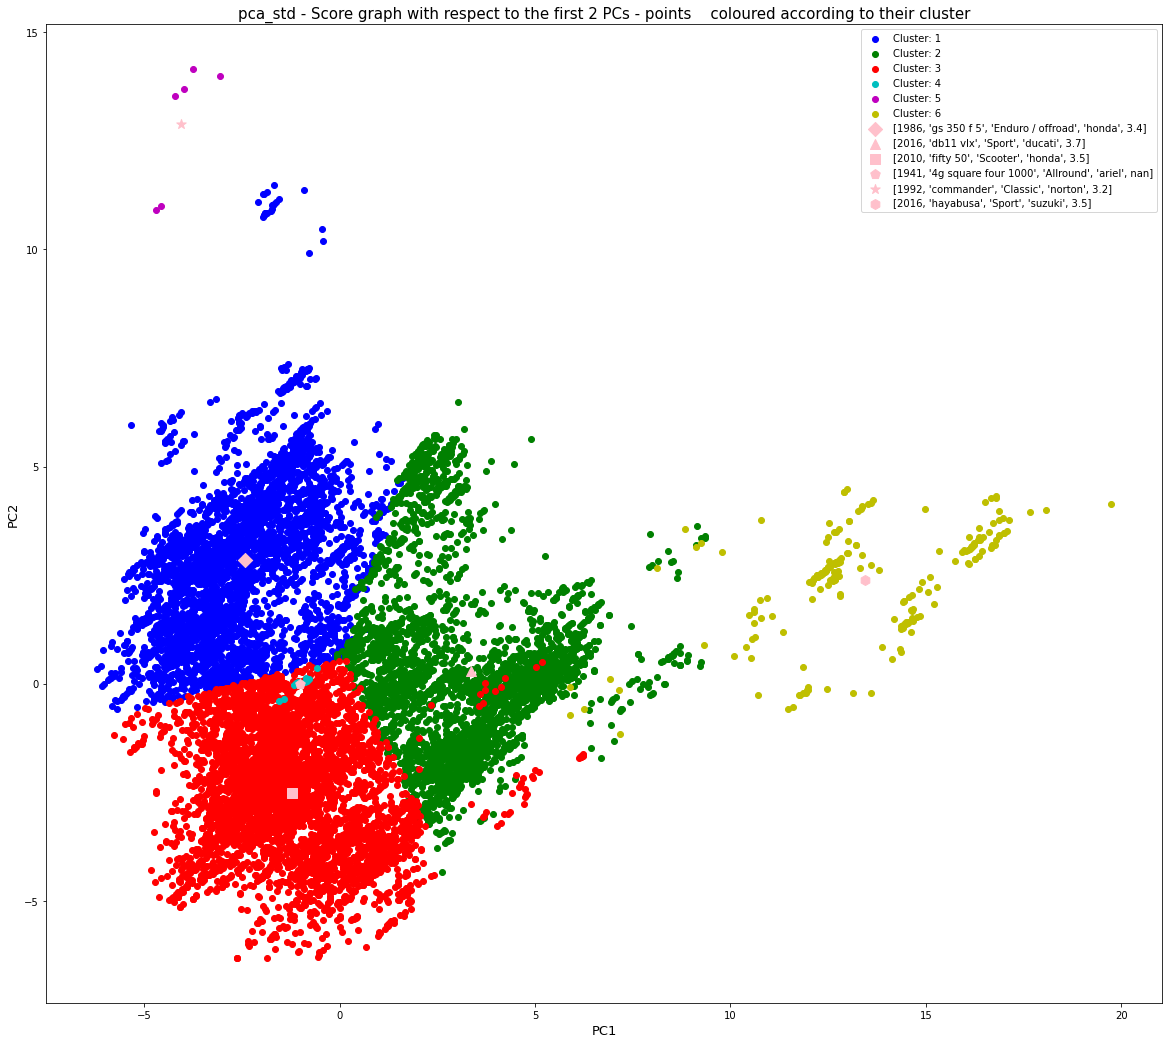

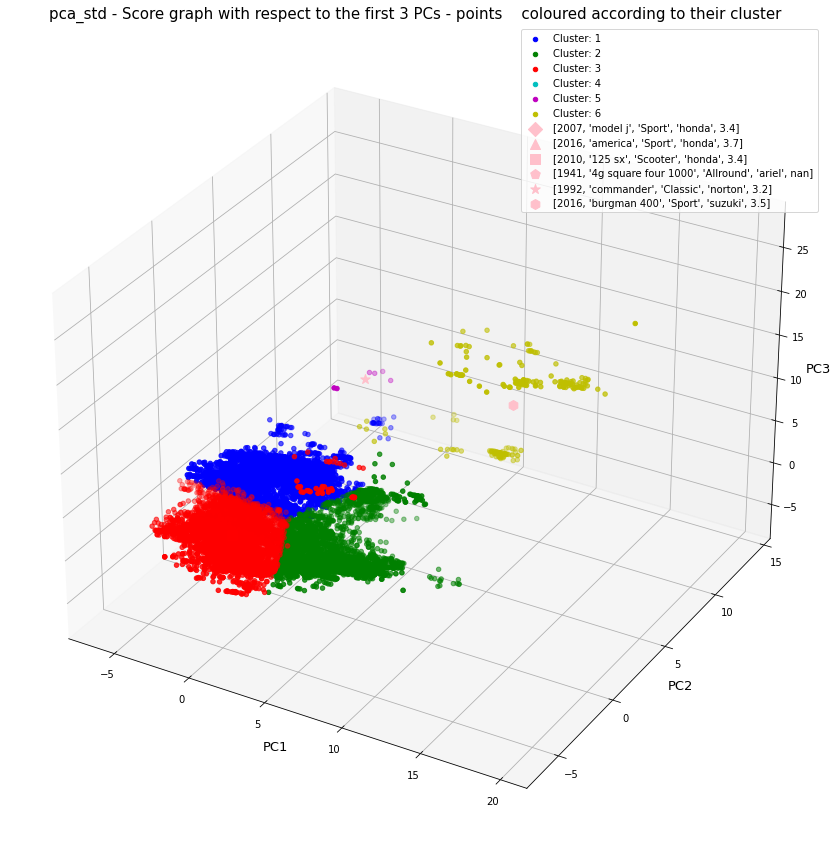

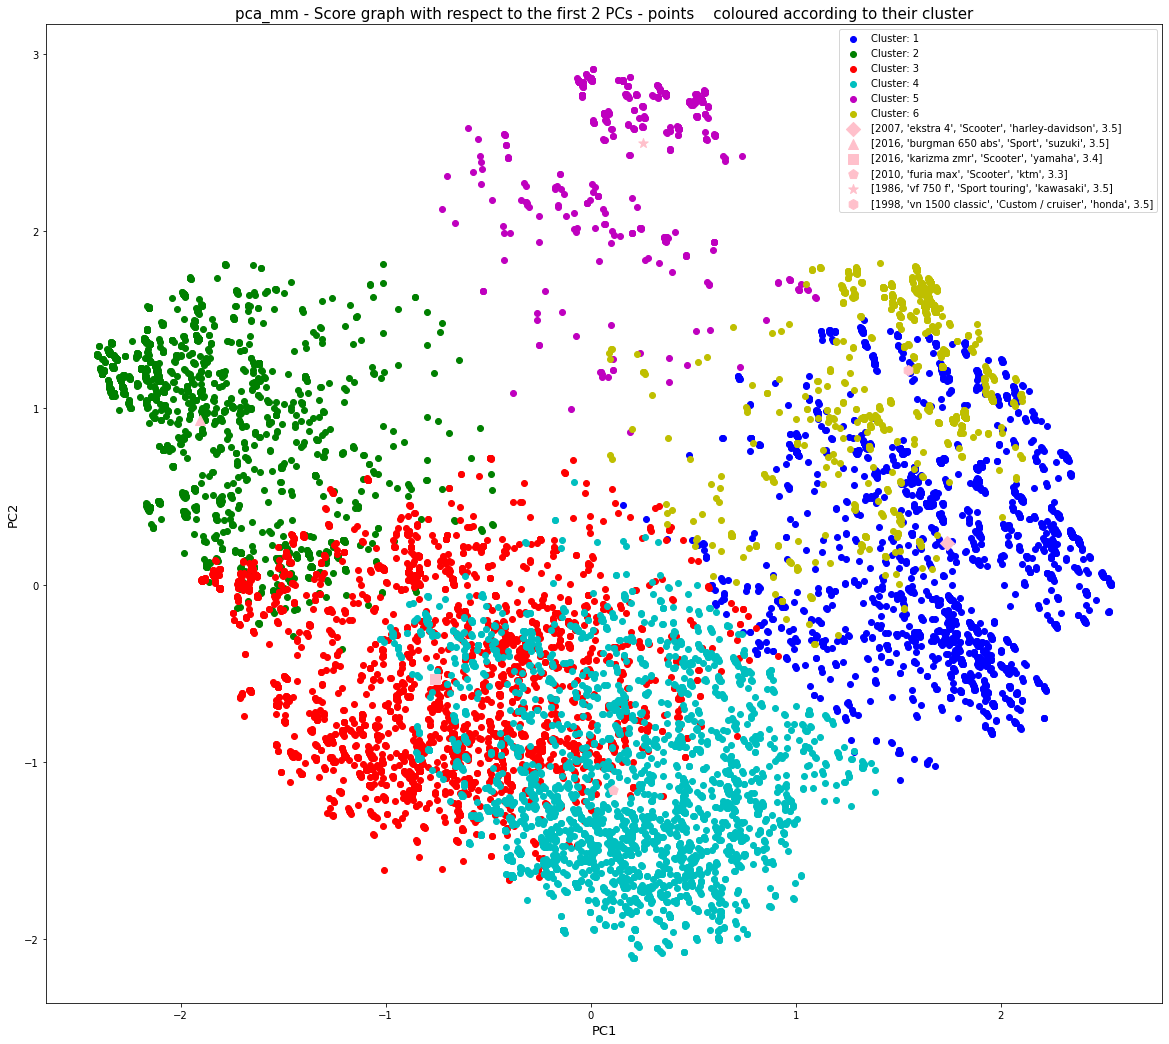

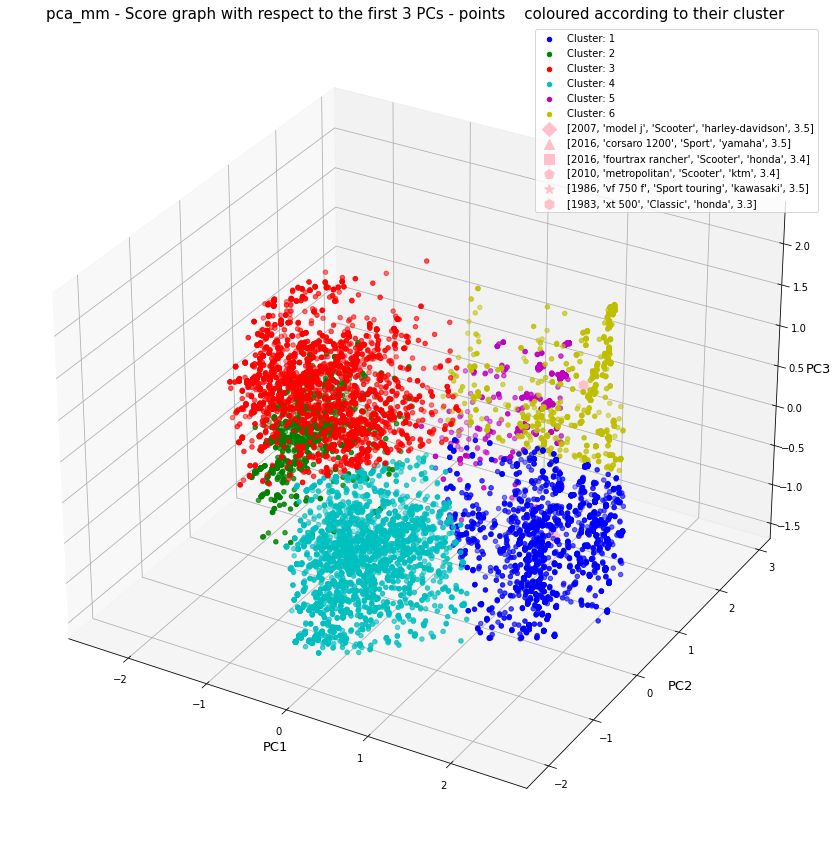

In [43]:
for key in keys_to_be_considered:
    df_transformed = pca_instances[key].transform(dataFrames[key])  # apply PCA
                                                                # transformation

    clusters = np.arange(0,k_best[key])

    # score graphs with respect to the first l PCs, with points coloured according
    #to their cluster
    l = 2
    plt.figure(figsize=(20, 18))
    for cluster in clusters:
        plt.scatter(df_transformed[kmeans[key].labels_ == cluster, 0],\
                    df_transformed[kmeans[key].labels_ == cluster, 1],\
                    c = color_dictionary[cluster],\
                    label=f"Cluster: {cluster+1}")
    plt.xlabel("PC1", fontsize=13)  # PC1 on axis x
    plt.ylabel("PC2", fontsize=13)  # PC2 on axis y
    plt.title(f'{key} - Score graph with respect to the first {l} PCs - points\
    coloured according to their cluster', fontsize=15)

    for cluster in clusters:
        # Assign a name to the centroid based on the labels of the points
        # belonging to the cluster.

        mask = kmeans[key].labels_ == cluster
        indices = np.where(mask)[0]
        corresponding_labels = workdf.iloc[indices]
        labels = []
        for label in labels_name:
            labels.append(corresponding_labels[label].tolist())
        assigned_labels = name_the_centroid(kmeans[key].\
                                            cluster_centers_[cluster, :l],\
                                            df_transformed[kmeans[key]\
                                                           .labels_ == cluster, :l],\
                                            labels)
        name = list(assigned_labels)
        #plt.text(kmeans[key].cluster_centers_[cluster, 0],\
        #kmeans[key].cluster_centers_[cluster, 1], "   "+str(name),\
        #ha='left', path_effects=[pe.withStroke(linewidth=5, foreground='white')])

        plt.scatter(kmeans[key].cluster_centers_[cluster, 0],\
                    kmeans[key].cluster_centers_[cluster, 1],\
                    s=100, c = color_dictionary[len(color_dictionary)-1],\
                    marker=marker_dictionary[cluster], label = name)   
                                                                # centroid plotted


    plt.legend()

    l = 3
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(111, projection='3d')
    for cluster in clusters:
        ax.scatter(df_transformed[kmeans[key].labels_ == cluster, 0],\
                   df_transformed[kmeans[key].labels_ == cluster, 1],\
                   df_transformed[kmeans[key].labels_ == cluster, 2],\
                   c = color_dictionary[cluster],\
                   label=f"Cluster: {cluster+1}")
    ax.set_xlabel("PC1", fontsize=13)  # PC1 on axis x
    ax.set_ylabel("PC2", fontsize=13)  # PC2 on axis y
    ax.set_zlabel("PC3", fontsize=13)  # PC3 on axis z
    plt.title(f'{key} - Score graph with respect to the first {l} PCs - points\
    coloured according to their cluster', fontsize=15)

    for cluster in clusters:
        # Assign a name to the centroid based on the labels of the points
        # belonging to the cluster.

        mask = kmeans[key].labels_ == cluster
        indices = np.where(mask)[0]
        corresponding_labels = workdf.iloc[indices]
        labels = []
        for label in labels_name:
            labels.append(corresponding_labels[label].tolist())
        assigned_labels = name_the_centroid(kmeans[key].\
                                            cluster_centers_[cluster, :l],\
                                            df_transformed[kmeans[key].\
                                                           labels_ == cluster, :l],\
                                            labels)
        name = list(assigned_labels)
        #ax.text(kmeans[key].cluster_centers_[cluster, 0],\
        #kmeans[key].cluster_centers_[cluster, 1], kmeans[key].cluster_centers\
        #_[cluster, 2], "   "+str(name), ha='left', path_effects=[pe.withStroke\
        #(linewidth=5, foreground='white')])

        ax.scatter(kmeans[key].cluster_centers_[cluster, 0],\
                   kmeans[key].cluster_centers_[cluster, 1],\
                   kmeans[key].cluster_centers_[cluster, 2],\
                   s=100, c = color_dictionary[len(color_dictionary)-1],\
                   marker=marker_dictionary[cluster], label = name)   
                                                                # centroid plotted


    plt.legend()

The clusters are plotted in a 2D scatter plot and in a 3D one. Points belonging to the same cluster are drawn in the same color.
The centroids of the clusters are also shown. They can be interpreted as the ‘average’ object in each cluster.


To each centroid a name that describes the average motorcycle in the cluster represented by it has been given.
To choose such name, the following criterion has been considered. The name to the centroid is assigned based on the surrounding points and their labels. In particular, all labels of all points of the cluster whose centroid has to be named have been taken into account. The name of the centroid is chosen as a list of features: each point contributes to the assignment of a specific label in an inversely proportional manner to its distance from the centroid. The closer a point is to the centroid, the higher its contribution is. (Note that if a point has a distance of zero, it contributes 10 times the maximum contribution to avoid infinite weight.)

# Exercise 7: Clusters and Centroids Evaluation (optional)
Internal and external evaluation of the clusters obtained from the k-Means algorithm applied to the principal components of the 2 datasets.

## Internal evaluation
The internal evaluation is done in terms of the silhouette score of the clusters.

In [44]:
for key in keys_to_be_considered:
    df_transformed = pca_instances[key].transform(dataFrames[key])[:, :m[key]]  # apply
                                                                    # PCA transformation
    # df_transformed = pd.DataFrame(df_transformed, columns=[f'PC{i+1}' for i\
    #in np.arange(m[key])])  # corresponding dataFrame
    ss = silhouette_score(df_transformed, kmeans[key].labels_)
    print(f'{key} - Sishouette score of the clusters (internal evaluation) = {ss}')

pca_std - Sishouette score of the clusters (internal evaluation) = 0.42636731649873116
pca_mm - Sishouette score of the clusters (internal evaluation) = 0.4644348402748279


## External evaluation
The external evaluation is done by looking at the distribution of the values of the available labels inside clusters.

### Labels distribution in the dataset (clusters independent)
Before the external evaluation, it is important to evaluate how the labels are distributed into the dataset, independently of the clusters.

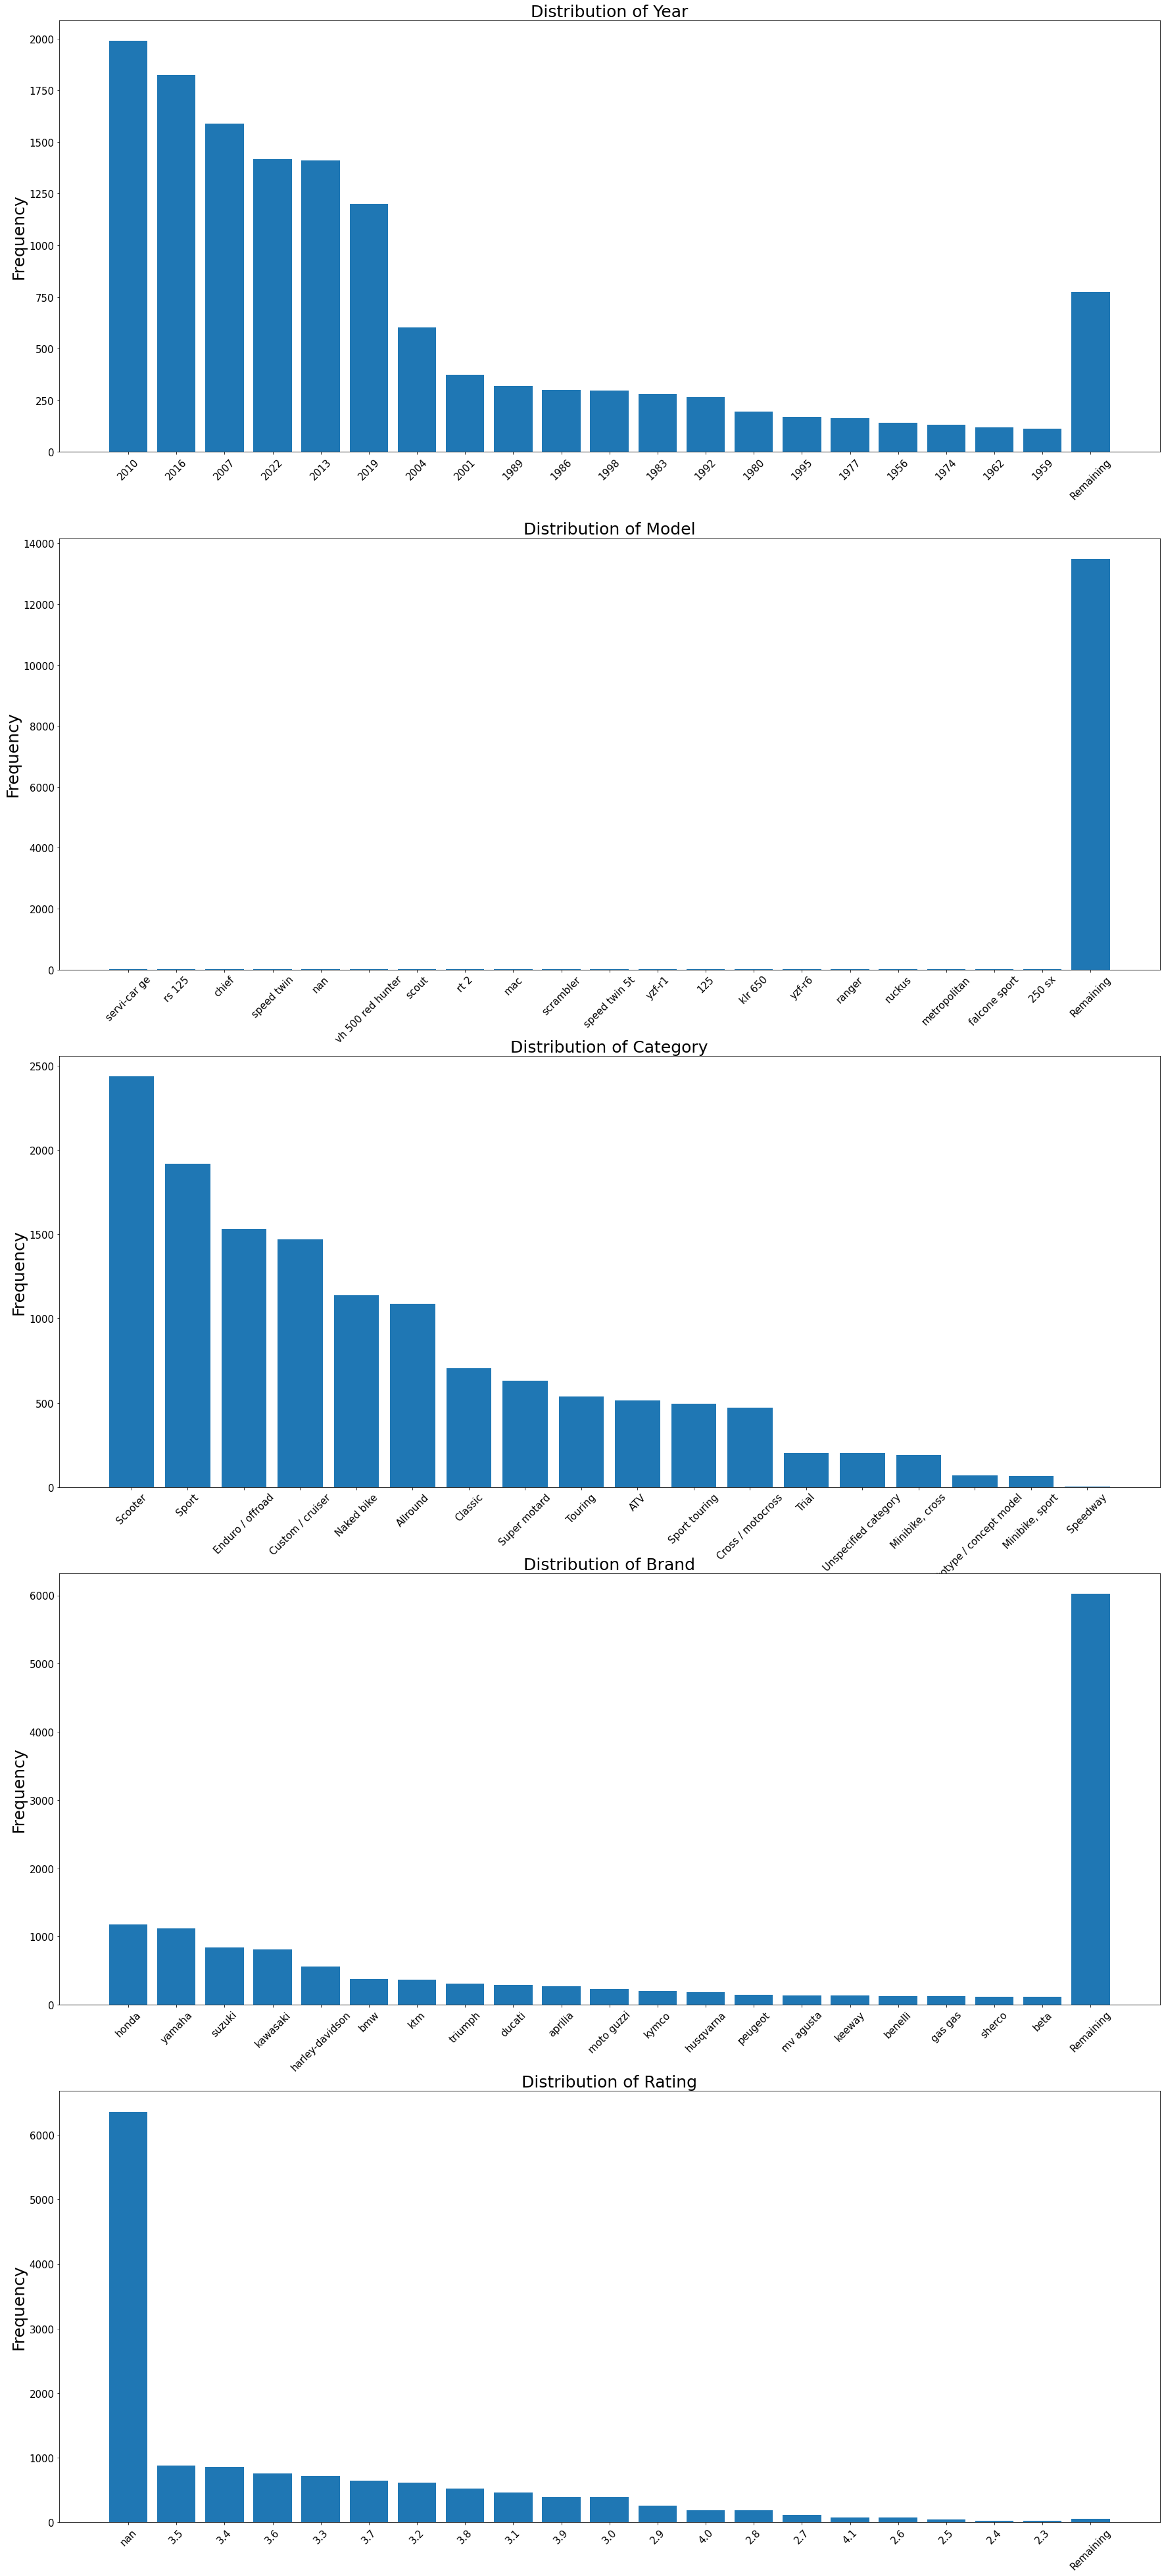

In [45]:
counts = {}
for label in labels_name:  # Calculate the counts for each label column
    counts[label] = workdf[label].astype(str).value_counts(dropna=False)

th = 20
plt.figure(figsize=(30, 70))
#plt.suptitle('Frequency of values for each label', fontsize = 40)
plot_counter = 1
for column, count in counts.items():
    if len(count)>th:
        count_top_th = count.head(th)
        sum_remaining = count.iloc[th:].sum()
        count_top_th['Remaining'] = sum_remaining
        plt.subplot(len(labels_name),1,plot_counter)
        plot_counter+=1
        plt.bar(count_top_th.index, count_top_th.values)
        #plt.xlabel('Values', fontsize = 25)
        plt.xticks(rotation=45, fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.ylabel('Frequency', fontsize = 25)
        plt.title(f"Distribution of {column}", fontsize = 25)
    else:
        plt.subplot(len(labels_name),1,plot_counter)
        plot_counter+=1
        plt.bar(count.index, count.values)
        #plt.xlabel('Values', fontsize = 25)
        plt.xticks(rotation=45, fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.ylabel('Frequency', fontsize = 25)
        plt.title(f"Distribution of {column}", fontsize = 25)

In [46]:
for column, count in counts.items():
    count_df = count.to_frame().reset_index()
    count_df.columns = [column, 'Frequency']
    display(count_df)

Year  Frequency
0   2010       1988
1   2016       1823
2   2007       1588
3   2022       1417
4   2013       1412
5   2019       1200
6   2004        601
7   2001        373
8   1989        320
9   1986        300
10  1998        298
11  1983        281
12  1992        266
13  1980        194
14  1995        169
15  1977        164
16  1956        142
17  1974        133
18  1962        118
19  1959        113
20  1965        107
21  1971         94
22  1953         91
23  1968         91
24  1950         52
25  1938         52
26  1932         34
27  1929         33
28  1935         31
29  1926         30
30  1941         29
31  1923         25
32  1947         24
33  1944         14
34  1917         14
35  1920         14
36  1914         11
37  1911          8
38  1908          6
39  1902          4
40  1899          3
41  1896          3
42  1905          3

Model  Frequency
0       servi-car ge         13
1             rs 125         12
2              chief         12
3         speed twin         10
4                nan         10
...              ...        ...
10053        nsr 125          1
10054  nsc110 vision          1
10055       ns 400 r          1
10056         nr 750          1
10057          z 300          1

[10058 rows x 2 columns]

Category  Frequency
0                     Scooter       2437
1                       Sport       1917
2            Enduro / offroad       1533
3            Custom / cruiser       1468
4                  Naked bike       1139
5                    Allround       1088
6                     Classic        706
7                Super motard        631
8                     Touring        538
9                         ATV        514
10              Sport touring        495
11          Cross / motocross        473
12                      Trial        202
13       Unspecified category        201
14            Minibike, cross        192
15  Prototype / concept model         70
16            Minibike, sport         64
17                   Speedway          5

Brand  Frequency
0              honda       1179
1             yamaha       1118
2             suzuki        839
3           kawasaki        809
4    harley-davidson        562
..               ...        ...
478              mbs          1
479           midual          1
480           swaygo          1
481          mission          1
482         livewire          1

[483 rows x 2 columns]

Rating  Frequency
0     nan       6361
1     3.5        877
2     3.4        855
3     3.6        759
4     3.3        717
5     3.7        645
6     3.2        618
7     3.8        528
8     3.1        464
9     3.9        396
10    3.0        390
11    2.9        264
12    4.0        189
13    2.8        183
14    2.7        121
15    4.1         78
16    2.6         74
17    2.5         48
18    2.4         28
19    2.3         21
20    2.2         14
21    4.2         10
22    2.1          9
23    2.0          9
24    1.9          5
25    1.7          3
26    4.3          3
27    1.8          2
28    1.5          1
29    4.4          1

As can be seen from the plots and the tables showing the distribution of each label:

- **Rating** label is not well-balanced, and, most importantly, it is not avalaible for more than 6000 entries. It cannot be useful to make an external evaluation of clusters;
- **Brand** is not well-balanced, there are hundreds of different values and many different values among the entries. The most frequent values are very frequent, but there are also many very rare values, making difficult to interpret them and to use them for external evaluation of clusters;
- **Model** is not well-balanced, there are thousands of different values, making difficult to interpret them and to use them for external evaluation of clusters;
- **Year** is not well-balanced, since recent years are much more frequent than others. They can not be used for clusters evaluation;
- **Category** is reasonably well-balanced. It is possible to try using it for clusters external evaluation.

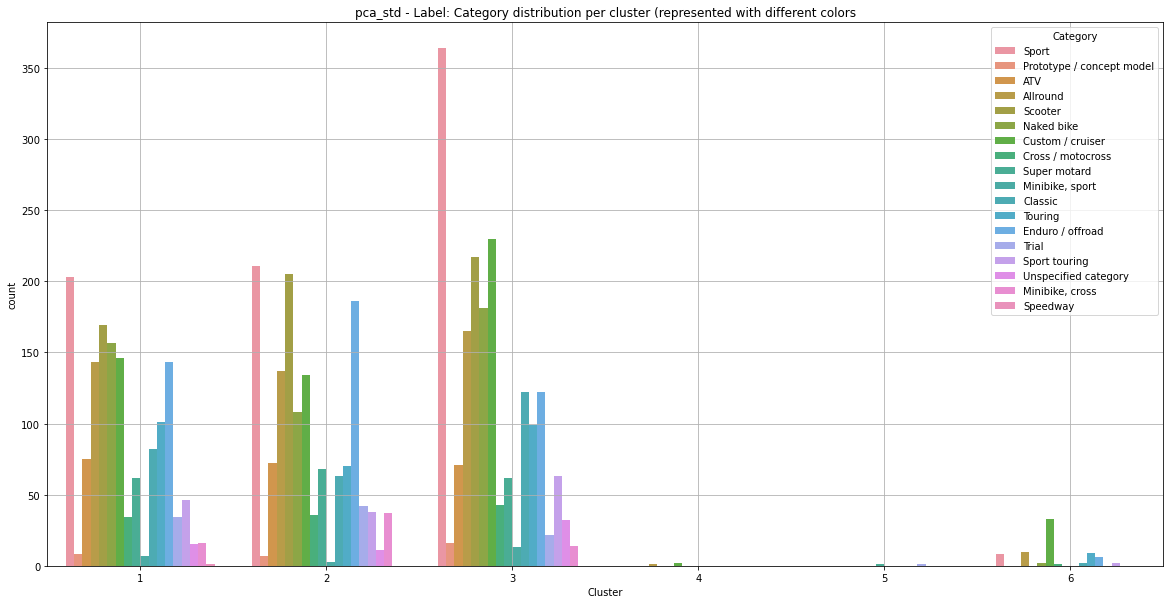

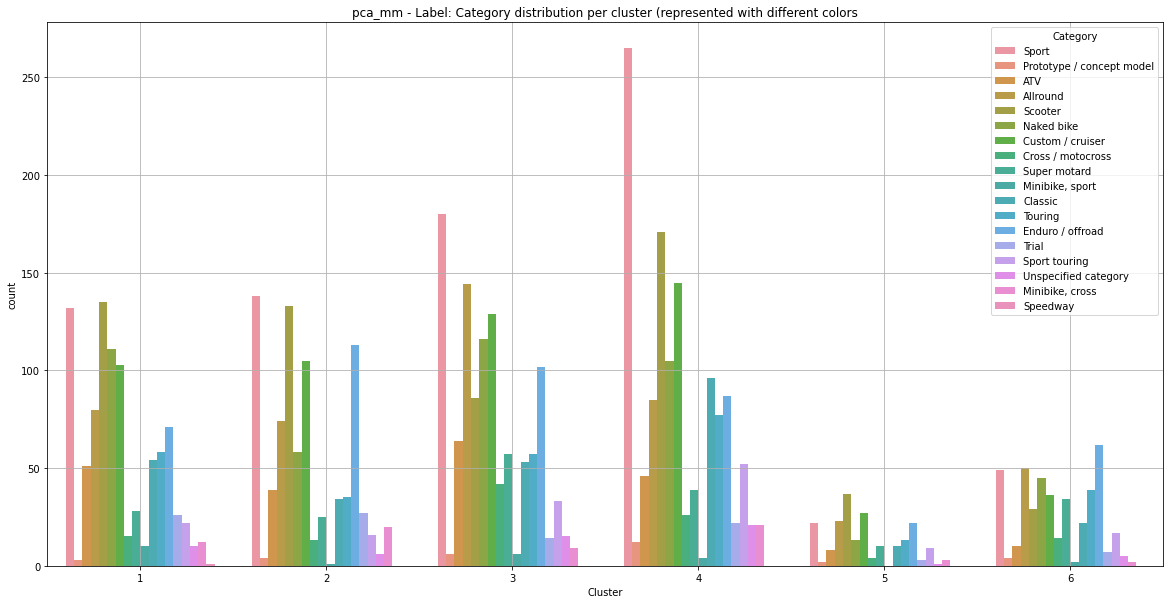

In [47]:
for key in keys_to_be_considered:
    dataFrames[key]['Category'] = workdf['Category'] # add a column with
                                                     # label to be considered
    dataFrames[key]['Cluster'] = kmeans[key].labels_ +1 # add an additional
                                                        # column with cluster id

    plt.figure(figsize=(20, 10))
    sns.countplot(x='Cluster', hue='Category', data=dataFrames[key])
    plt.title(f'{key} - Label: Category distribution per cluster (represented\
    with different colors')
    plt.grid()
    plt.show()

As can be seen from the plots above, **Category** label is not so meaningful in performing external evaluation of clusters.

In the standard-scaled data, the values are spread across the first 3 clusters. The only interesting label values are the *sport* value which is predominant in cluster 3 and *custom/cruiser* value which is much more frequent in cluster 5 than all other values. In addition, most of 'Category information' is in the first 3 clusters.

In the min/max-scaled data, the values are spread across all the clusters. The only interesting label values is the *sport* value which is much more frequent in cluster 2 than all other values.

This can also be noticed by the representation of the data in the PCs space, where different categories do not involve the occurrence of interesting patterns of categories in the PCs space.